# Starbucks Capstone Challenge


***


## 0 - Project Overview

### Introduction
Users of the __Starbucks rewards mobile app__ receive an __offer__ once every few days. An offer can by anything from pure informational content to an actual discount or a buy-one-get-one-free promotion. However, offers are not send out to every user and even those that receive one might not all get the same.

One of Starbucks' goals behind sending out offers is to __increase the response__ of its app users. On the one hand, response can refer to the frequency of transactions and on the other to amounts spent. However, if and how users respond, depends on the types of offers being sent as well as user specific (socio-)demographic characteristics. In fact, not getting the fit between the two right can have a significant effect on Starbucks financial performance.

### Problem Statement
The goal of this project is to __optimize Starbucks' promotion strategy__, whereas the focus lies on maximizing __transaction profits__ per user. In order to do so, I'm going to explore __two different approaches__ of finding the right types of offers for each individual Starbucks app user. The first one is an __analytical solution__ to the problem - simple yet effective - that extracts the optimal combination of offer types including expected transaction profits for different demographic groups. The second one involves __linear and tree-based regression models__ as well as simulations of monetary response for each app user and possible offer type combinations. In the end, both solutions will have to prove their validity against a __benchmark__ of Starbucks current offer response.

### Metrics
#### Primary
The primary metric I am going to look at when trying to solve the problem at hand is the transaction __profit per user__ made by Starbucks. 
It is defined as follows:

\begin{equation}
PPU(O,D) = \frac{1}{N}*{{\sum}}_{n=0}^{\ N}\frac{(A_u - R_u)}{T_u}
\end{equation}
Where:
- _PPU = (Transaction) Profit Per User_
- _O = Set of Offers_
- _D = User Demographics_
- _A = Total Amount Spent_
- _R = Total Reward Received_
- _T = Total Number of Transactions_
- _U = User_
- _N = Number of Users_

As the number of users N is fixed in our data set, we aim for an increase of average transaction profits of each individual app user. The revenues considered for doing this are all revenues made from __in-app transactions__. In turn, costs are __rewards paid__ to users when they complete an offer. As transaction amounts of single users can differ from day to day and week to week and as rewards are only paid when pre-defined dollar amounts are reached, we are going to focus on user averages.

This is of course a very __simplified version of reality__. However, the aim of this project is not to construct a perfect picture, but to explore different solutions that tackle the problem at hand. The$\ PPU$ will then be especially useful when __comparing different solutions__ among each other.

#### Secondary
As secondary metric I am going to use:
- __Adjusted__$\ R^{2}$
- __Mean Absolute Error__ ($\\MAE$)

I do need both metrics in order to evaluate __fit and predictive power__ of a regression model, developed as one solution later in this project. While$\ R^{2}$ alone already tells us what proportion of the __variance__ of$\ PPU$ can be __explained__ by our regression model, it's adjusted version helps us to control for not adding features with little explanatory influence. Despite looking at model fit, $\\MAE$ is used to make sure that our model __predicts$\ PPU$ correctly__. Only then we can be confident in using the model for optimizing Starbuck's offer sendout strategy.

### Data Sets
The data sets used in this project contain simulated data that mimics customer behavior on the Starbucks rewards mobile app. However, it's a simplified version of the real Starbucks app because the underlying simulator has only one product whereas Starbucks actually sells dozens of products.

Once every few days, Starbucks __sends out an offer__ to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. Also, not all users receive the same offer, and that is the challenge to solve with this data set.

Every offer has a __validity period__ before it expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

The transactional data shows user __purchases__ made on the app including the timestamp of purchase and the amount of money spent on a purchase. It also has a record for each offer that a user __receives__ as well as a record for when a user actually __views__ the offer. There are also records for when a user __completes__ an offer. Keep in mind as well that someone using the app might make a purchase through the app __without having received an offer__ or seen an offer.

We also need to take into account that some __demographic groups__ will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. Therefore, we need to try to assess what a certain demographic group will __buy when not receiving__ any offers.

#### Example
A user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

#### Files
The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - validity of offer in days
* channels (list of strings) - communcation channel e.g. email

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

### Project Outline
The __work__ in this notebook is __structured__ as follows:
1. Exploratory Analysis
2. Modeling
    - Pre-Processing
    - Implementation & Refinement
3. Results
4. Conclusion
5. Limitations & Improvements

***

## 1 - Exploratory Analysis

### 1.1 - Library Imports

In [647]:
# General libraries
import pandas as pd
import numpy as np
import json
import datetime
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import progressbar
from scipy import stats

# Regression model
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.externals import joblib
import xgboost as xgb

# Plot/Preview settings
pd.set_option('display.max_columns', None)
% matplotlib inline
sns.set_palette('Blues_r')

# Surpress pandas warnings
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

### 1.2 - Data Set Imports

In [648]:
# Read in the json files of offer portfolio and app user profile data
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)

In [649]:
# Because the json import of the transcript data didn't work with pandas
# I came up with a work aroung which I put in the following function

def load_transcript(path):
    ''' Loads transcript data from json file
    
     Args:
        path (str): Path to json file of the transcript data
    Returns:
        DataFrame: Returns a pandas data frame of the transcript data
    '''
    
    # Transcript data couldn't be loaded with standard pandas read function
    transcript_dict = []
    for line in open(path, 'r'):
        if line.strip():
            transcript_dict.append(json.loads(line.strip()))

    # Create pandas data frame from dictionary
    transcript = pd.DataFrame(transcript_dict)
    
    # The value column with its key-value pairs needs to be 
    # further converted to actual columns
    transcript_values = pd.DataFrame(transcript['value'].tolist())

    # Merge duplicate offer_id columns
    transcript_values.columns = ['amount', 'offer_id', 'offer_id2', 'reward']
    transcript_values['offer_id'] = np.where(transcript_values['offer_id'].isnull(),
                                             transcript_values['offer_id2'],
                                             transcript_values['offer_id'])

    # Add to transcript data frame
    transcript = transcript.drop('value', axis=1)
    transcript_values = transcript_values.drop('offer_id2', axis=1)
    transcript = pd.concat([transcript, transcript_values], axis=1)
    
    # Sort data frame and reset index
    transcript = transcript.sort_values(['person', 'time'])
    transcript = transcript.reset_index(drop=True)
    
    return transcript

In [650]:
# Read in the json files of transcript data
transcript_path = 'data/transcript.json'
transcript = load_transcript(transcript_path)

### 1.3 - Exploration
In the following section I'm going to take __a closer look at each of the given data sets__. Getting familiar with them is the first step before running more structured pre-processing steps in section 3.

### Portfolio

Let's start with Starbucks offer portfolio.

In [651]:
# Show portfolio data
print(portfolio.shape)
portfolio

(10, 6)


channels  difficulty  duration  \
0       [email, mobile, social]          10         7   
1  [web, email, mobile, social]          10         5   
2          [web, email, mobile]           0         4   
3          [web, email, mobile]           5         7   
4                  [web, email]          20        10   
5  [web, email, mobile, social]           7         7   
6  [web, email, mobile, social]          10        10   
7       [email, mobile, social]           0         3   
8  [web, email, mobile, social]           5         5   
9          [web, email, mobile]          10         7   

                                 id     offer_type  reward  
0  ae264e3637204a6fb9bb56bc8210ddfd           bogo      10  
1  4d5c57ea9a6940dd891ad53e9dbe8da0           bogo      10  
2  3f207df678b143eea3cee63160fa8bed  informational       0  
3  9b98b8c7a33c4b65b9aebfe6a799e6d9           bogo       5  
4  0b1e1539f2cc45b7b9fa7c272da2e1d7       discount       5  
5  2298d6c36e964ae4a3e7e9706d1fb8c2       discount       3  
6  fafdcd668e3743c1bb461111dcafc2a4       discount       2  
7  5a8bc65990b245e5a138643cd4eb9837  informational       0  
8  f19421c1d4aa40978ebb69ca19b0e20d           bogo       5  
9  2906b810c7d4411798c6938adc9daaa5       discount       2

Let's compare the offers from the portfolio __based on their offer type__ and numeric columns such as:
- "difficulty"
- "duration"
- "reward"

I'm also going to add a seventh column, "minimum_profit_margin", in order to compare possible __implications on revenues/profits__.

In [1356]:
# Let's compare all offer types along their mean difficulty, duration and rewards
offer_types = portfolio.copy()

# Add minimum expected profit for completed offer
offer_types['minimum_profit_margin'] = (1 - (offer_types['reward'] / offer_types['difficulty'])).fillna(0)

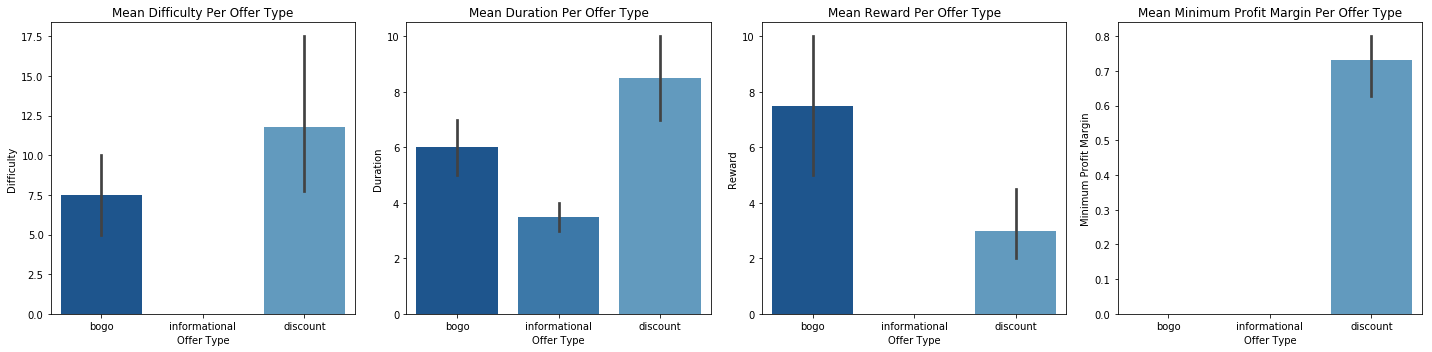

In [1357]:
# Create sub-plots
fig, ax = plt.subplots(1,4, figsize = (20,5))

# Plot grouped box plots
for idx, col in enumerate(['difficulty','duration','reward','minimum_profit_margin']):
    sns.barplot(x='offer_type', y=col, data=offer_types, ax = ax[idx])
    y_label = col.replace('_',' ').title()
    ax[idx].set_ylabel(y_label)
    ax[idx].set_xlabel('Offer Type')
    ax[idx].set_title('Mean ' + y_label + ' Per Offer Type')
    plt.tight_layout();

#### Observations
- __Ten__ different offers in __three__ distinct categories: __BOGO__ offers (4x), __informational__ offers (2x) & __discounts__ (4x)
- BOGO and informational offers __do not__ guarantee positive effect on financials result as they have a minimum profit margin of 0%
- Discounts are the __only offers__ with positive minimum profit marging for completed offers (at least 71%)

In [654]:
# Possible to add channel analysis with ...
pd.concat([portfolio, pd.get_dummies(portfolio['channels'].apply(pd.Series).stack()).sum(level=0)], axis=1).groupby('offer_type').sum()

difficulty  duration  reward  email  mobile  social  web
offer_type                                                             
bogo                   30        24      30      4       4       3    3
discount               47        34      12      4       3       2    4
informational           0         7       0      2       2       1    1

### Profile

Next, we continue by checking out the __Starbucks app user account profile__ data.

In [655]:
# Preview profile data
print(profile.shape)
profile.head()

(17000, 5)


age  became_member_on gender                                id    income
0  118          20170212   None  68be06ca386d4c31939f3a4f0e3dd783       NaN
1   55          20170715      F  0610b486422d4921ae7d2bf64640c50b  112000.0
2  118          20180712   None  38fe809add3b4fcf9315a9694bb96ff5       NaN
3   75          20170509      F  78afa995795e4d85b5d9ceeca43f5fef  100000.0
4  118          20170804   None  a03223e636434f42ac4c3df47e8bac43       NaN

First of all, let's double check if there are any duplicates and if the number of records also represents the __number of users__ in the data set.

In [656]:
# Check for duplicates and remove if true
if profile.drop_duplicates().shape != profile.shape:
    n_rows = profile.shape[0]
    profile = profile.drop_duplicates()
    print('Dropped {} duplicate rows from profile data set.'.format(n_rows - profile.shape[0]))
else:
    print('No duplicates found.')

No duplicates found.


In [657]:
# Check number of unque users
if profile['id'].nunique() == profile.shape[0]:
    print('Each records in the profile data represent one unique user.')

Each records in the profile data represent one unique user.


Only from the preview we can already see that we might get a problem with __missing values__ here. Both columns, "gender" and "income" show missing values encoded as "None" on the one hand and "NaN" on the other. At the same time the column "age" seems to show the value "118" for each record with missing values in "gender" and "income".

In [658]:
# Let's check for missing values first
profile.isnull().sum() / profile.shape[0] * 100

age                  0.000000
became_member_on     0.000000
gender              12.794118
id                   0.000000
income              12.794118
dtype: float64

In [659]:
# Then let's check for the meaning of the value "118" in the "age" column
profile['age'].value_counts().head()

118    2175
58      408
53      372
51      363
54      359
Name: age, dtype: int64

#### Observations
- Approx. 13% of users __didn't leave any__ profile information in the Starbucks app
- Value counts of "age" column confirms our first intuition: Starbucks app users who didn't leave any information on gender and income also didn't leave any information on age and __missing values for were simply re-encoded as "118"__. For ease-of-use I'm going to reverse this transformation and re-introduce missing values.

In [660]:
# Reverse replacement of missing values in "age" columns
profile['age'] = np.where(profile['age'] == 118, np.nan, profile['age'])

# Check number of missing values (should match number of "118"s)
print('Number of missing values: {}'.format(profile['age'].isnull().sum()))

Number of missing values: 2175


I'm going to add another column to data frame which uses the "became_member_on" column to express an __app user's member age__. Unfortunately, it isn't possible to evaluate an exact member age at the time of viewing or completing an offer as timestamps in the transcrip data are only given as hours, whereas the profile data contains dates.

In [661]:
# Create datetime from "became_member_on"
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d', errors='ignore')

# Calculate member age in days
current_date = datetime.datetime.now()
profile['member_age'] = (current_date - profile['became_member_on']).dt.days / 365.25
profile = profile.drop('became_member_on', axis=1)

Now that we've completed the most important pre-processing steps for the profile data it's time to look at the data.

In [662]:
# Summary statistics
profile.describe().round(2)

age     income  member_age
count  14825.00   14825.00    17000.00
mean      54.39   65404.99        1.90
std       17.38   21598.30        1.13
min       18.00   30000.00        0.48
25%       42.00   49000.00        1.05
50%       55.00   64000.00        1.46
75%       66.00   80000.00        2.65
max      101.00  120000.00        5.47

Summary statistics are nice way to get a first overview of what one might expect from the data:

The __median Starbucks app user__:
- Is __rather old__ with a median age of 55 years; this is 1.44x the age of the median American [1]
- Earns __more than twice__ as much money than median American: __\\$64,000 vs. \\$31,099__ (2016) [2]
- Has started using the app approximately __one and a half years__ ago

Sources:
- [1] https://en.wikipedia.org/wiki/List_of_countries_by_median_age
- [2] https://fred.stlouisfed.org/series/MEPAINUSA672N#0

-

In order to get the complete picture one should also always look at the __distribution__ of values across columns. Below, I'm going to do this in two ways:
- Plot distributions __in buckets__ to facilitate visual interpretation
- Plot distributions __as is__ in case the created buckets miss anything

Please note: Each bucket ranges from bucket number to number of next bucket (including lower/excluding upper bound) and income buckets represent income in 1000s.

In [663]:
# Create column buckets
profile['age_bucket'] = np.floor(profile['age'] / 10) * 10
profile['income_bucket'] = np.floor(profile['income'] / 10000) * 10
profile['member_age_bucket'] = np.floor(profile['member_age'])

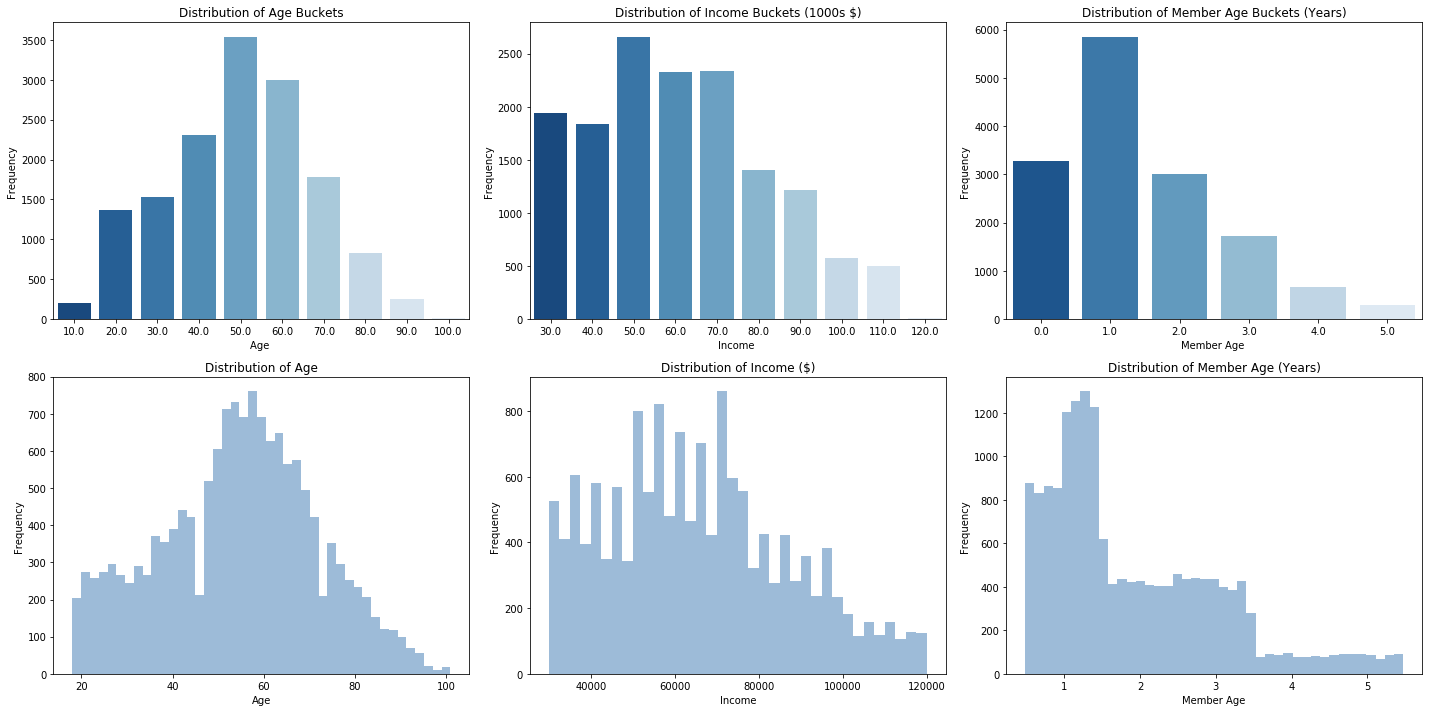

In [664]:
# Create sub-plots
fig, ax = plt.subplots(2,3, figsize = (20,10))

# Plot histograms across buckets
cols = ['age_bucket','income_bucket','member_age_bucket']

for idx, col in enumerate(cols):
    sns.barplot(x=col, y=col, data=profile.dropna(), estimator=lambda x: len(x), palette='Blues_r', ax=ax[0,idx])
    x_label = col.replace('bucket','').replace('_',' ').title()
    ax[0,idx].set_ylabel('Frequency')
    ax[0,idx].set_xlabel(x_label)
    ax[0,idx].set_title('Distribution of ' + x_label + 'Buckets')

# Plot histograms
cols = ['age','income','member_age']

for idx, col in enumerate(cols):
    sns.distplot(profile[col].dropna(), hist=True, kde=False, ax=ax[1,idx])
    x_label = col.replace('_',' ').title()
    ax[1,idx].set_ylabel('Frequency')
    ax[1,idx].set_xlabel(x_label)
    ax[1,idx].set_title('Distribution of ' + x_label)
    plt.tight_layout()
    
# Adjust plot titles
ax[0,1].set_title('Distribution of Income Buckets (1000s $)')
ax[0,2].set_title('Distribution of Member Age Buckets (Years)')
ax[1,1].set_title('Distribution of Income ($)')
ax[1,2].set_title('Distribution of Member Age (Years)');

In [ ]:
y_vars = ['difficulty','duration','reward','minimum_profit_margin']
i = 0
for row in range(2):
    for col in range(2):
        sns.barplot(x='offer_type', y=y_vars[i], data=offer_types, ax = ax[row,col])
        y_label = y_vars[i].replace('_',' ').title()
        ax[row,col].set_ylabel(y_label)
        ax[row,col].set_xlabel('Offer Type')
        ax[row,col].set_title('Mean ' + y_label + ' Per Offer Type')
        plt.tight_layout();
        i += 1

#### Observations
- The __age__ of users is only slighty skewed to the right and __almost centered__ around the mean
- A slight right skew in the distribution of Starbucks app users' __income__ shows that only a small number of customer are very __wealthy people__
- The __member age__ histogram reveals how Starbucks was able to significantly __increase monthly registrations__ from time to time

### Transcript

Last, but not least we will look at the transcript data.

In [665]:
# Preview transcript data
print(transcript.shape)
transcript.head()

(306534, 6)


event                            person  time  amount  \
0  offer received  0009655768c64bdeb2e877511632db8f   168     NaN   
1    offer viewed  0009655768c64bdeb2e877511632db8f   192     NaN   
2     transaction  0009655768c64bdeb2e877511632db8f   228   22.16   
3  offer received  0009655768c64bdeb2e877511632db8f   336     NaN   
4    offer viewed  0009655768c64bdeb2e877511632db8f   372     NaN   

                           offer_id  reward  
0  5a8bc65990b245e5a138643cd4eb9837     NaN  
1  5a8bc65990b245e5a138643cd4eb9837     NaN  
2                               NaN     NaN  
3  3f207df678b143eea3cee63160fa8bed     NaN  
4  3f207df678b143eea3cee63160fa8bed     NaN

Before we dig deeper into the datat set, let's check for __duplicate rows__.

In [666]:
# Check for duplicates and remove if true
if transcript.drop_duplicates().shape != transcript.shape:
    n_rows = transcript.shape[0]
    transcript = transcript.drop_duplicates()
    print('Dropped {} duplicate rows from transcript data set.'.format(n_rows - transcript.shape[0]))
else:
    print('No duplicates found.')

Dropped 397 duplicate rows from transcript data set.


Each row in the transcript data frame describes __1 out of 306,137 events of the 17,000 registered Starbucks app users__. Users can either __receive, view and complete an offer__ or __make a transactions__. Whenever a user completes 1 out of the 10 offers available in the Starbucks portfolio he receives a reward. However, receiving rewards means making transactions first until an offer-specific amount is reached.

In order to get a feeling for how Starbucks app user interact with the offers they receive, how much money they spend and how different offers perform financially, we're going to collect some simple __aggregations of the data__ first.

In [667]:
# General overview
print('Number of events                          : {}'.format(transcript.shape[0]))
print('Number of users                           : {}'.format(transcript['person'].nunique()))
print('Number of days                            : {}'.format(int(np.floor(transcript['time'].max() / 24))))
print('Number of offers                          : {}'.format(transcript['offer_id'].nunique()))

# User counts
print('\nNumber of users who received an offer     : {}'.format(transcript[transcript['event'] == 'offer received']['person'].nunique()))
print('Number of users who viewed an offer       : {}'.format(transcript[transcript['event'] == 'offer viewed']['person'].nunique()))
print('Number of users who completed an offer    : {}'.format(transcript[transcript['event'] == 'offer completed']['person'].nunique()))
print('Number of users who made a transactions   : {}'.format(transcript[transcript['event'] == 'transaction']['person'].nunique()))

# Event counts
print('\nNumber of offer sendout days              : {}'.format(transcript[transcript['event'] == 'offer received']['time'].nunique()))
print('Number of offer receptions                : {}'.format(transcript[transcript['event'] == 'offer received'].shape[0]))
print('Number of offer views                     : {}'.format(transcript[transcript['event'] == 'offer viewed'].shape[0]))
print('Number of offer completions               : {}'.format(transcript[transcript['event'] == 'offer completed'].shape[0]))
print('Number of transactions                    : {}'.format(transcript[transcript['event'] == 'transaction'].shape[0]))

# Event counts per user
print('\nAverage number of offers received / user  : {:.2f}'.format(transcript[transcript['event'] == 'offer received'].groupby('person').count()['offer_id'].mean()))
print('Average number of offers viewed / users   : {:.2f}'.format(transcript[transcript['event'] == 'offer viewed'].groupby('person').count()['offer_id'].mean()))
print('Average number of offers completed / user : {:.2f}'.format(transcript[transcript['event'] == 'offer completed'].groupby('person').count()['offer_id'].mean()))
print('Average number of transactions / user     : {:.2f}'.format(transcript[transcript['event'] == 'transaction'].groupby('person').size().mean()))

# Event counts per offer
print('\nAverage number of recipients / offer      : {:.2f}'.format(transcript[transcript['event'] == 'offer received'].groupby('offer_id').size().mean()))
print('Average number of viewers / offer         : {:.2f}'.format(transcript[transcript['event'] == 'offer viewed'].groupby('offer_id').size().mean()))
print('Average number of completers / offer      : {:.2f}'.format(transcript[transcript['event'] == 'offer completed'].groupby('offer_id').size().mean()))

# Financials (totals)
print('\nTotal amount spent on transaction         : {:.2f}$'.format(transcript['amount'].sum()))
print('Total reward received on completion       : {:.2f}$'.format(transcript['reward'].sum()))

# Financials (averages)
print('\nAverage amount spent / transaction        : {:.2f}$'.format(transcript['amount'].mean()))
print('Average reward received / completion      : {:.2f}$'.format(transcript['reward'].mean()))
print('Average amount spent / user               : {:.2f}$'.format(transcript.groupby('person').mean()['amount'].mean()))
print('Average reward received / user            : {:.2f}$'.format(transcript.groupby('person').mean()['reward'].mean()))

Number of events                          : 306137
Number of users                           : 17000
Number of days                            : 29
Number of offers                          : 10

Number of users who received an offer     : 16994
Number of users who viewed an offer       : 16834
Number of users who completed an offer    : 12774
Number of users who made a transactions   : 16578

Number of offer sendout days              : 6
Number of offer receptions                : 76277
Number of offer views                     : 57725
Number of offer completions               : 33182
Number of transactions                    : 138953

Average number of offers received / user  : 4.49
Average number of offers viewed / users   : 3.43
Average number of offers completed / user : 2.60
Average number of transactions / user     : 8.38

Average number of recipients / offer      : 7627.70
Average number of viewers / offer         : 5772.50
Average number of completers / offer      : 4147.75

T

#### Observations
- Transcript data holds observations of offer events and transactions for a __period of 29 days__
- Sendouts for the __10 offers__ from the portfolio happened on __6 distinct days__
- Eventhough __99%__ of all app users __received an offer__ at least once, we observe an overall __conversion rate of 57%__ only (= 33182 / 57725)
- Starbucks app users make __transactions every 3-4 days__ (= 29 / 8.38) during which they __spend 13.68\\$__ on average
- __Every ~3rd__ of these transactions __completes an offer__ (= 8.38 / 2.60) leading to an average __reward of 4.75\\$__
- Because the distribution of transaction amounts across users is largely skewed, Starbucks is still able to achieve an overall __profit margin of 91%__, if we consider paying rewards the only costs in this analysis (= 1 - (162679.00 / 1775451.97)

Let's take a look at __how offer events and transactions are distributed over time__ in order to understand the temporal relationship between each other.

In [668]:
# Prepare data for plot of events
events = transcript.copy()

# Transform column values
events['event'] = events['event'].str.title()
events['time'] = np.floor(events['time'] / 24)

# Group data frame
events = pd.DataFrame(events.groupby(['event','time'],as_index=False).size()).reset_index()
events.columns = ['Event','Day','Number of Events']

events.head()

Event  Day  Number of Events
0  Offer Completed  0.0              1014
1  Offer Completed  1.0              1025
2  Offer Completed  2.0               848
3  Offer Completed  3.0               655
4  Offer Completed  4.0               480

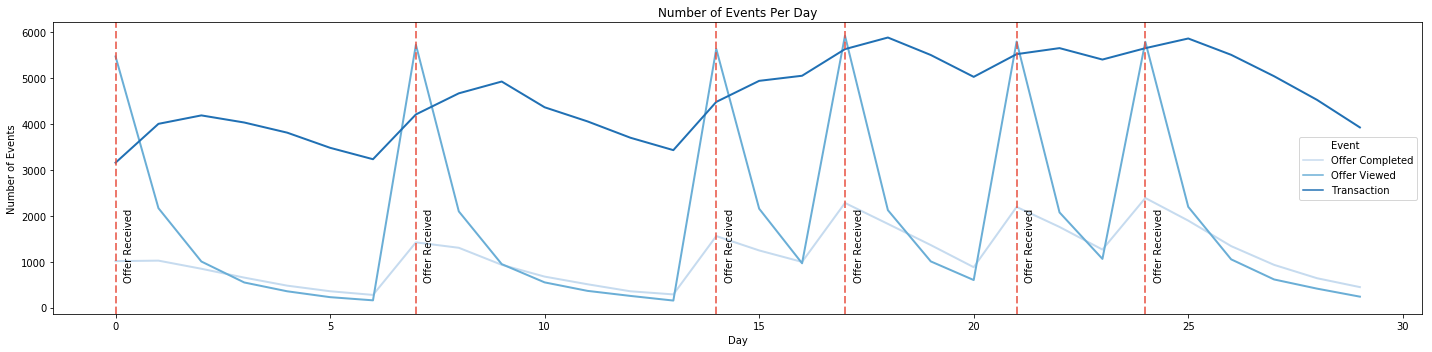

In [669]:
# Set plot size
fig, ax = plt.subplots(1,1, figsize = (20,5))

# Plot time series of offer events (excluding 'offer received')
ax = sns.lineplot(x="Day", y='Number of Events', hue="Event", data=events[events['Event'] != 'Offer Received'], palette='Blues', linewidth=2.)

# Plot lines for days of offer sendout
for time in events[events['Event'] == 'Offer Received']['Day']:
    plt.axvline(x=time, linestyle='--', linewidth=2., alpha=0.75, color='#e74c3c')
    plt.text(time+0.2, 2000, 'Offer Received', rotation=90)
    plt.tight_layout()
    
# Label plot
ax.set_ylabel('Number of Events')
ax.set_xlabel('Day')
ax.set_title('Number of Events Per Day')
plt.tight_layout()

#### Observations
- Starbucks sent out offers on __6 distinct days__ within the 29 days period covered in the transcript data frame
- The majority of offer __views__ happen on the __day of sendout__
- Actual __transactions peak slighty delayed__ within a few days after an offer was sent out
- Shorter __timespans between offer__ sendouts past day 14 seem to cause a larger overall number of transactions
- However, increase in overall number of transactions may also caused by a __growing number of previously__ seen offers

In contrast to looking at pure transaction and offer event frequencies, we should keep an eye financials such __revenues and costs__ i.e. transaction amounts and paid rewards.

In [670]:
# Prepare data for plot of events
fins = transcript[transcript['event'].isin(['transaction', 'offer completed'])].copy()

# Transform column values
fins['event'] = fins['event'].str.title()
fins['time'] = np.floor(fins['time'] / 24)

# Group data frame
transforms = {'amount':'sum','reward':'sum','person':'nunique'}
fins = pd.DataFrame(fins.groupby(['time'],as_index=False).agg(transforms)).reset_index()
#events = pd.DataFrame(events.groupby(['event','time'],as_index=False).sum()).reset_index()
fins = fins[['time','amount','reward','person']]

# Add metric
fins['profit_per_user'] = (fins['amount'] - fins['reward']) / fins['person']
fins['profit_margin'] = 1 - fins['reward'] / fins['amount']
fins.columns = ['Day','Amount','Reward','Users','PPU', 'Margin']

fins.head()

Day    Amount  Reward  Users        PPU    Margin
0  0.0  44050.34  5113.0   2778  14.016321  0.883928
1  1.0  49977.02  5184.0   3390  13.213280  0.896272
2  2.0  52121.14  4390.0   3573  13.358841  0.915773
3  3.0  47690.57  3210.0   3440  12.930398  0.932691
4  4.0  48467.81  2305.0   3332  13.854385  0.952443

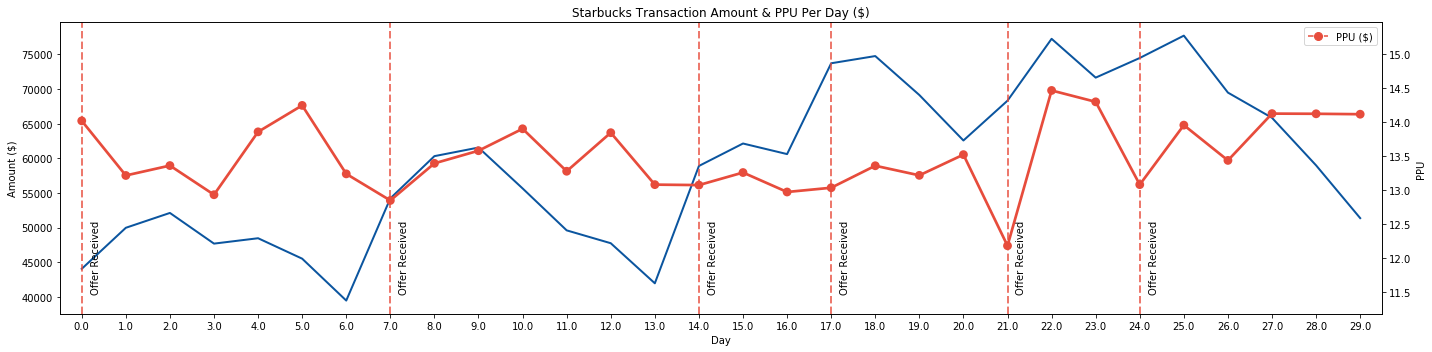

In [1359]:
# Set plot size
fig, ax = plt.subplots(1,1, figsize = (20,5))

# Plot time series of offer events (excluding 'offer received')
p = sns.lineplot(x="Day", y='Amount', data=fins, palette='Blues', linewidth=2.)

# Plot lines for days of offer sendout
for time in events[events['Event'] == 'Offer Received']['Day']:
    plt.axvline(x=time, linestyle='--', linewidth=2., alpha=0.75, color='#e74c3c')
    plt.text(time+0.2, 50000, 'Offer Received', rotation=90)
    plt.tight_layout()
    
# Add second axis
ax2 = p.twinx()
sns.pointplot(x='Day', y='PPU', data=fins, alpha=0.75, color='#e74c3c', ax=ax2)
ax2.set_ylim(fins['PPU'].min() - 1, fins['PPU'].max() + 1)
marker = mlines.Line2D([], [], color='#e74c3c', marker='o', linestyle='--', markersize=8, label='PPU ($)')
ax2.legend(handles=[marker], loc='best')
    
# Label plot
ax.set_ylabel('Amount ($)')
ax.set_xlabel('Day')
ax.set_title('Starbucks Transaction Amount & PPU Per Day ($)')
plt.tight_layout()

#### Observations
- While increased transaction frequencies lead to an increased amount of revenues, the __profit per user__ remains __stable over time__
- The main reason behind this is that an __increased exposure to offers__ also leads to more offer completions and more frequently __paid rewards__

Please take a look at the next graph in order to understand the relationship between transactions amounts and paid rewards over time.

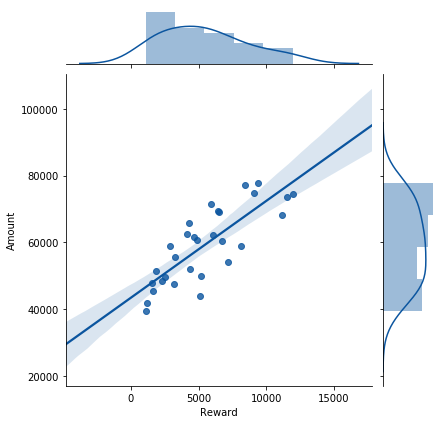

In [672]:
# Relationship between "reward" and "amount" over time
sns.jointplot(x='Reward',y='Amount', data=fins, kind='regr');

-

The very brief numerical summary of the transcript data frame above revealed an overall offer __conversion rate of 57%__. However, this conversion rate is likely to be __different for different offers and offer types__. Also, it doesn't yet consider the fact, that users might have __viewed an offer way past completing it__. Modeling conversion rate correctly so they reflect the actual influence of offers on a users behaviour requires additional pre-processing steps which we will run later in this notebook.

Assuming that offer views past offer completions are evenly distributed across all offers, we are now not really interested in the magnitude of conversion rates, but in the __comparison__ between them.

In [673]:
# Compare conversion rates for different offer types
# Get offer types
conversion_rate = transcript.merge(portfolio, left_on='offer_id', right_on='id', how='left').groupby(['offer_type', 'event']).size().reset_index()

# Reshape data
conversion_rate = pd.pivot_table(conversion_rate, index='offer_type', columns='event', values=0).reset_index()
conversion_rate.columns = ['offer_type','offer_completed','offer_received','offer_viewed']

# Calculate conversion rate
conversion_rate['conversion_rate'] = conversion_rate['offer_completed'] / conversion_rate['offer_viewed']

conversion_rate

offer_type  offer_completed  offer_received  offer_viewed  \
0           bogo          15501.0         30499.0       25449.0   
1       discount          17681.0         30543.0       21445.0   
2  informational              NaN         15235.0       10831.0   

   conversion_rate  
0         0.609101  
1         0.824481  
2              NaN

In [674]:
# Compare conversion rates for different offers
conversion_rate = transcript.copy()

# Reshape data
conversion_rate = pd.pivot_table(conversion_rate, index='offer_id', columns='event', values='person', aggfunc='size').reset_index()
conversion_rate.columns = ['offer_id','offer_completed','offer_received','offer_viewed']
conversion_rate['offer_completed'] = conversion_rate['offer_completed'].fillna(0)

# Calculate conversion rate
conversion_rate['conversion_rate'] = conversion_rate['offer_completed'] / conversion_rate['offer_viewed']

conversion_rate

offer_id  offer_completed  offer_received  \
0  0b1e1539f2cc45b7b9fa7c272da2e1d7           3340.0          7668.0   
1  2298d6c36e964ae4a3e7e9706d1fb8c2           5112.0          7646.0   
2  2906b810c7d4411798c6938adc9daaa5           3964.0          7632.0   
3  3f207df678b143eea3cee63160fa8bed              0.0          7617.0   
4  4d5c57ea9a6940dd891ad53e9dbe8da0           3301.0          7593.0   
5  5a8bc65990b245e5a138643cd4eb9837              0.0          7618.0   
6  9b98b8c7a33c4b65b9aebfe6a799e6d9           4303.0          7677.0   
7  ae264e3637204a6fb9bb56bc8210ddfd           3635.0          7658.0   
8  f19421c1d4aa40978ebb69ca19b0e20d           4262.0          7571.0   
9  fafdcd668e3743c1bb461111dcafc2a4           5265.0          7597.0   

   offer_viewed  conversion_rate  
0        2663.0         1.254225  
1        7337.0         0.696743  
2        4118.0         0.962603  
3        4144.0         0.000000  
4        7298.0         0.452316  
5        6687.0         0.000000  
6        4171.0         1.031647  
7        6716.0         0.541245  
8        7264.0         0.586729  
9        7327.0         0.718575

Whereas it doesn't become quite clear in the comparison of offer types, it's pretty obvious when looking at conversion rates of distinct offers: Conversion rates of __greater than 100%__ are a strong indicator that some offers are __being completed without app users being aware__ of them. Thus, before we can continue to calculate offer specific conversion rates, we need to apply __additional pre-processing__ steps to the transcript data set.

However, to still get a feeling of how Starbucks offers are being completed we can use an __adjusted version__ of the conversion rate, knowing that the results don't capture the actual influence, but rather offer completion patterns in general.

In [675]:
# Add short version of "id" to portfolio data in order to facilitate working with offer ids e.g. for plotting
portfolio['offer_id_short'] = portfolio.index.values + 1

# Add offer types
conversion_rate = conversion_rate.merge(portfolio[['id','offer_id_short','offer_type']], left_on='offer_id', right_on='id', how='left')
conversion_rate = conversion_rate.drop(['id','offer_id'], axis=1)
conversion_rate = conversion_rate.rename(columns = {'offer_id_short':'offer_id'})
conversion_rate = conversion_rate.sort_values('offer_id')

# Calculate conversion rate
conversion_rate['conversion_rate'] = conversion_rate['offer_completed'] / conversion_rate['offer_received']

Then, as informational offers don't have any completion events we are going to __plot__ the adjusted conversion rates for both __BOGO and discount__ promotions.

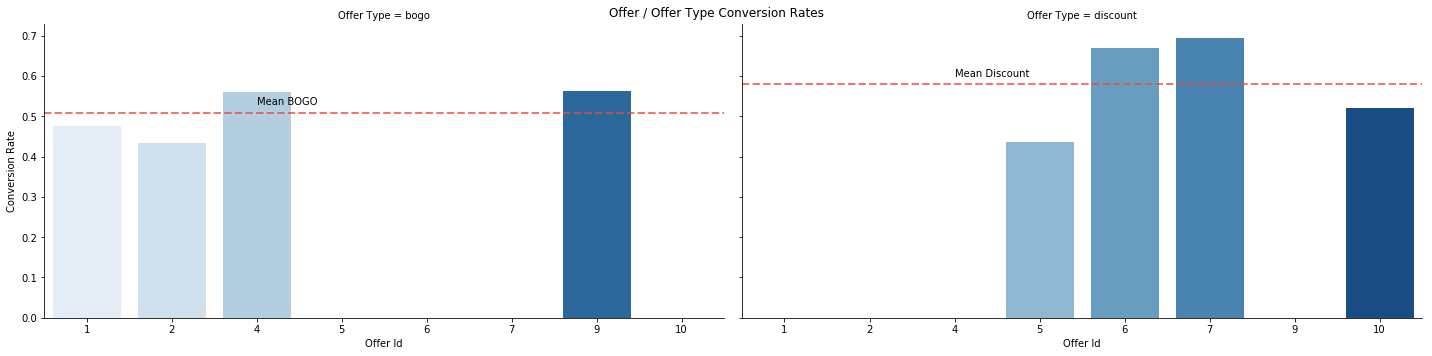

In [676]:
# Change column name and value formatting
conversion_rate.columns = [x.replace('_',' ').title() for x in conversion_rate.columns]

# Plot grouped barchat
p = sns.catplot(x='Offer Id', y='Conversion Rate', col='Offer Type', data=conversion_rate[conversion_rate['Offer Type'] != 'informational'],
                kind='bar', palette='Blues', height=5, aspect=2)

# Get reference values
bogo_mean = conversion_rate.groupby('Offer Type').mean()['Conversion Rate'][0]
discount_mean = conversion_rate.groupby('Offer Type').mean()['Conversion Rate'][1]

# Add reference lines
ax1, ax2 = p.axes[0]

ax1.axhline(y=bogo_mean, linestyle='--', linewidth=2., alpha=0.75, color='#e74c3c')
ax2.axhline(y=discount_mean, linestyle='--', linewidth=2., alpha=0.75, color='#e74c3c')
ax1.text(2, bogo_mean+0.02, "Mean BOGO")
ax2.text(2, discount_mean+0.02, "Mean Discount")

# Add title
p.fig.suptitle('Offer / Offer Type Conversion Rates')

plt.tight_layout();

#### Observations
- __Discounts__ seem to be the type of offer that are being __completed more often__ as compared to __buy-one-get-one__ offers (60% vs. 51% conversion rate)
- Conversion rate __standard deviations__ (12.27% vs. 6.39%) as well as both __graphs__ above reveal, that this really depends on the performance of individual offers
- BOGO offers clearly win in terms of __consistency__

I'd like to note another important thing here: __Larger conversion rates__ are not neccessarily better than smaller ones. In the end, Starbuck is interested in __maximizing income per user__ and while the conversion rate does contribute to the equation, looking at it alone ignores transaction amounts and rewards paid to users.

In [677]:
# Reshape data
rewards = pd.pivot_table(transcript, index='offer_id', columns='event', values='reward', aggfunc='sum').reset_index()[['offer_id','offer completed']]
rewards.columns = ['offer_id','reward']

# Add offer types
rewards = rewards.merge(portfolio[['id','offer_id_short','offer_type']], left_on='offer_id', right_on='id', how='left')
rewards = rewards.drop(['id','offer_id'], axis=1)
rewards = rewards.rename(columns = {'offer_id_short':'offer_id'})
rewards = rewards.sort_values('offer_id')
rewards['reward'] = rewards['reward'].fillna(0)

# Add conversion rates
rewards['conversion_rate'] = conversion_rate['Conversion Rate']

rewards

reward  offer_id     offer_type  conversion_rate
7  36350.0         1           bogo         0.474667
4  33010.0         2           bogo         0.434743
3      0.0         3  informational         0.000000
6  21515.0         4           bogo         0.560505
0  16700.0         5       discount         0.435576
1  15336.0         6       discount         0.668585
9  10530.0         7       discount         0.693037
5      0.0         8  informational         0.000000
8  21310.0         9           bogo         0.562938
2   7928.0        10       discount         0.519392

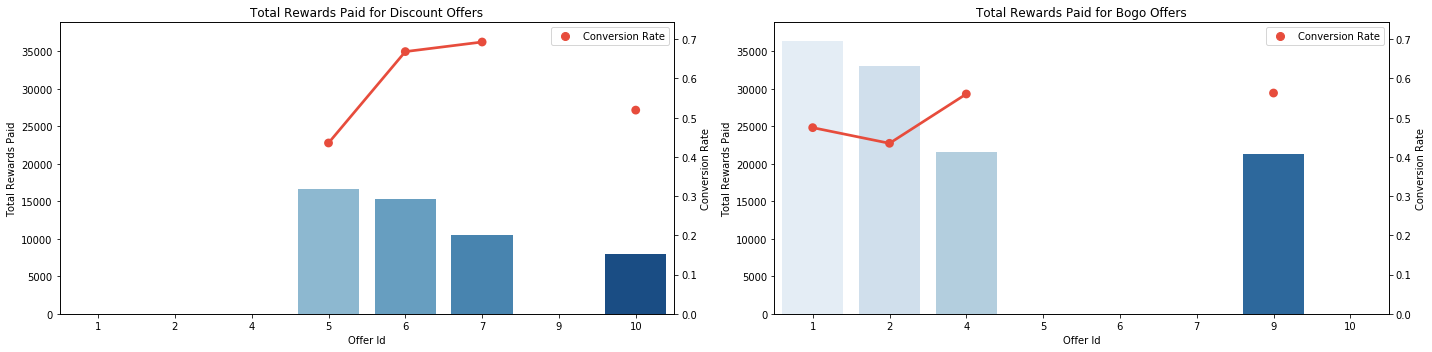

In [678]:
# Change column name and value formatting
rewards.columns = [x.replace('_',' ').title() for x in rewards.columns]

# Create sub-plots
fig, ax = plt.subplots(1,2, figsize = (20,5))

# Plot grouped bar chart
for idx, col in enumerate(['discount','bogo']):
    # Adjust column values
    rwrds_small = rewards[rewards['Offer Type'] != 'informational'].copy()
    rwrds_small['Reward'] = np.where(rwrds_small['Offer Type'] != col, 0, rwrds_small['Reward'])
    rwrds_small['Conversion Rate'] = np.where(rwrds_small['Offer Type'] != col, np.nan, rwrds_small['Conversion Rate'])
    
    # Plot bar chart on first y-axis
    sns.barplot(x='Offer Id', y='Reward', data=rwrds_small, ax=ax[idx], palette='Blues')
    y_label = col.replace('_',' ').title()
    ax[idx].set_ylabel('Total Rewards Paid')
    ax[idx].set_xlabel('Offer Id')
    ax[idx].set_title('Total Rewards Paid for ' + col.title() + ' Offers')
    ax[idx].set_ylim(0, rewards['Reward'].max() + 2500)
    
    # Plot points on second y-axis
    ax2 = ax[idx].twinx()
    sns.pointplot(x='Offer Id', y='Conversion Rate', data=rwrds_small, alpha=0.75, color='#e74c3c', ax=ax2)
    ax2.set_ylim(0, rewards['Conversion Rate'].max() + 0.05)
    marker = mlines.Line2D([], [], color='#e74c3c', marker='o', linestyle='None', markersize=8, label='Conversion Rate')
    ax2.legend(handles=[marker], loc='best')

    plt.tight_layout();

In [679]:
# Average total amount of rewards paid for offers by offer type
print('Average amount of rewards paid to for BOGO offers    : {}$'.format(
    rewards[rewards['Offer Type'] == 'bogo']['Reward'].mean()))
print('Average amount of rewards paid to for discount offers: {}$'.format(
    rewards[rewards['Offer Type'] == 'discount']['Reward'].mean()))

# Correlation between total amount of rewards paid for offers and offer conversion rate
print('\nCorrelation between rewards paid for offers and offer converion rates: {:.2f}'.format(
    rewards[rewards['Offer Type'] != 'informational'][['Reward','Conversion Rate']].corr().values[1,0]))

Average amount of rewards paid to for BOGO offers    : 28046.25$
Average amount of rewards paid to for discount offers: 12623.5$

Correlation between rewards paid for offers and offer converion rates: -0.56


#### Observations
- For both discount offers as well as BOGO offers the plots reveal a rather __negative relationship between__ the amount of __rewards__ paid to app users for completing an offer and an offer's __conversion rate__
- Visual evaluation of this relationship is confirmed by __negative correlation coefficient of -0.56__
- __BOGO offers__ do not only have a __lower conversion rate__ on average (previous chart), but are also __2.2x more expensive__ for Starbucks

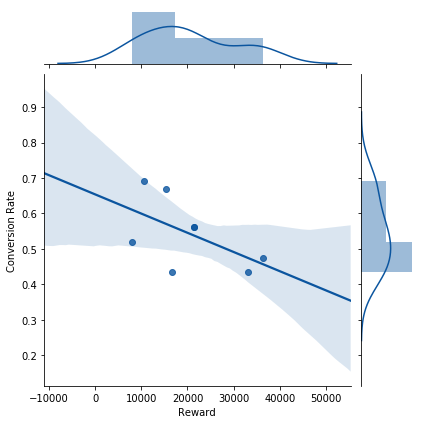

In [680]:
# Another plot to confirm the negative relationsip between reward amounts and conversion rates
sns.jointplot(x='Reward', y='Conversion Rate', data=rewards[rewards['Offer Type'] != 'informational'], kind='regr');

#### Final Note
As mentioned earlier in the notebook, the analysis did so far only concentrate on either offers and rewards or transactions. However, looking at __conversions alone ignores__ how offers may influence the __purchase and spending behaviour__ of Starbucks app users. 

Filling the __missing link__ between those three variables will be focus within the __next section__ of the notebook.

***

## 2 - Modeling

### 2.1 - Pre-Processing

In the following section, I will __combine pre-processing steps__ used earlier in the notebook as well as new steps in order to avoid running multiple cells multiple times and to get one step closer to a hands on performance analysis of offers, that includes __transaction amounts and rewards correctly linked to offers__.

The section is divided into the following parts:
1. Reading in files
2. Pre-processing of
    - Portfolio data
    - Profile data
    - Transcript data
    - Transaction events
    - Offer events

### Data Loader
As we don't want to load every single file over and over again, I'm going to put all these __steps combined__ into a function. As these are the foundation for any subsequent analyses, I will add the __removal of duplicates__ from transcript data here as well.

In [681]:
def load_data():
    ''' Loads portfolio, profile and transcript data from json files
    
    Args:
        None
    Returns:
        DataFrame: Returns three pandas data frames with: portfolio, profile and transcript data
    '''
    # Read in data
    print('Reading files ...')
    
    # Portfolio data
    portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
    print('... portfolio data imported. Shape of data: {}'.format(portfolio.shape))  
    
    # Profile data
    profile = pd.read_json('data/profile.json', orient='records', lines=True)
    print('... profile data imported. Shape of data: {}'.format(profile.shape))  
    
    # Transcript data
    transcript = load_transcript('data/transcript.json')
    transcript = transcript.drop_duplicates()
    print('... transcript data imported. Shape of data: {}'.format(transcript.shape))
    
    return portfolio, profile, transcript

In [682]:
# Run function
portfolio, profile, transcript = load_data()

Reading files ...
... portfolio data imported. Shape of data: (10, 6)
... profile data imported. Shape of data: (17000, 5)
... transcript data imported. Shape of data: (306137, 6)


### Portfolio Data
As offers from Starbucks offer portofolio tend to be quite long in the given data set, I'm going to add a __short version of "offer_id"__ to improve __readability__ when offers are used as columns later on.

In [683]:
# Add a much simpler offer_id to the portfolio data set
def preprocess_portfolio(df):
    ''' Pre-processes portfolio data
    
    Adds an additional column "offer_id_short" as easier to read/
    work with variable to profile data.
      
    Args:
        df (DataFrame): Pandas data frame of portfolio data
    Returns:
        DataFrame: Returns a pandas data frame of portfolio data
    '''
    df['offer_id_short'] = df.index.values + 1
    
    return df

In [684]:
# Run function
portfolio = preprocess_portfolio(portfolio)

print(portfolio.shape)
portfolio.head()

(10, 7)


channels  difficulty  duration  \
0       [email, mobile, social]          10         7   
1  [web, email, mobile, social]          10         5   
2          [web, email, mobile]           0         4   
3          [web, email, mobile]           5         7   
4                  [web, email]          20        10   

                                 id     offer_type  reward  offer_id_short  
0  ae264e3637204a6fb9bb56bc8210ddfd           bogo      10               1  
1  4d5c57ea9a6940dd891ad53e9dbe8da0           bogo      10               2  
2  3f207df678b143eea3cee63160fa8bed  informational       0               3  
3  9b98b8c7a33c4b65b9aebfe6a799e6d9           bogo       5               4  
4  0b1e1539f2cc45b7b9fa7c272da2e1d7       discount       5               5

### Profile Data
I'm going to add another column to data frame which uses the "became_member_on" column to express an app __user's member age__. Unfortunately, it isn't possible to evaluate an exact member age at the time of viewing or completing an offer as timestamps in the transcrip data are only given as hours, whereas the profile data contains dates.

Missing values in the column __"age"__ were replaced with the value "118". I'm going to __reverse this replacement__ as age follows an ordinal scale and replacing missing values with a large number doesn't seem to preserve the natural ordering.

In [685]:
# Pre-processing of profile data
def preprocess_profile(df):
    ''' Pre-processes profile data
    
    1. Convert "gender" column to str
    2. Adds an additional column "member_age" as days since app account registration
    3. Reverses encoding of missing values in "age" column
      
    Args:
        df (DataFrame): Pandas data frame of profile data
    Returns:
        DataFrame: Returns a pandas data frame of profile data
    '''
    # Convert "gender" to str
    df['gender'] = df['gender'].astype(str)
    
    # Create datetime from "became_member_on"
    df['became_member_on'] = pd.to_datetime(df['became_member_on'], format='%Y%m%d', errors='ignore')

    # Calculate member age in days
    current_date = datetime.datetime.now()
    df['member_age'] = (current_date - df['became_member_on']).dt.days
    df = df.drop('became_member_on', axis=1)
    
    # Reverse replacement of missing values in "age" columns
    df['age'] = np.where(df['age'] == 118, np.nan, df['age'])

    return df

In [686]:
# Run function
profile = preprocess_profile(profile)

print(profile.shape)
profile.head()

(17000, 5)


age gender                                id    income  member_age
0   NaN   None  68be06ca386d4c31939f3a4f0e3dd783       NaN         705
1  55.0      F  0610b486422d4921ae7d2bf64640c50b  112000.0         552
2   NaN   None  38fe809add3b4fcf9315a9694bb96ff5       NaN         190
3  75.0      F  78afa995795e4d85b5d9ceeca43f5fef  100000.0         619
4   NaN   None  a03223e636434f42ac4c3df47e8bac43       NaN         532

### Transcript
The transcript data holds information on events around offers as well as transactions. In order to evaluate if __one or more offers had an influence__ on a users purchase behaviour we need to compare transaction timestamps with validity periods of individual offers. The comparison as well as the transformation of the data set __requires a couple of steps__, as outlined below:
- Calculate __rewards__ received by app users
- Add __offer numbers__ to transcript data to keep track of situations where users receive the __same offer more than once__
- Add unique __transaction IDs__ to transcript data to keep track of "transaction" events
- Separate __transaction events__ including amounts paid and received from offer events
- Separate __offer events__ including timestamps from transaction events
- Make __comparison__ between transaction and offer events

I will again put those pre-processing steps into functions to clean up the whole process.

Starting with the rewards data set ...

In [687]:
# Retrieve timestamps and sums of rewards received by app users
def preprocess_rewards(df):
    ''' Retrieves rewards received by app users from transcript data
    
    Args:
        df (DataFrame): Pandas data frame of transcript data
    Returns:
        DataFrame: Returns a pandas data frame of rewards received per user and timestamp
    '''
    rewards = df[df['event'] == 'offer completed'][['person','time','reward']]
    rewards = pd.DataFrame(rewards.groupby(['person','time'], as_index=False).sum())
    
    return rewards

In [688]:
# Run function
rewards = preprocess_rewards(transcript)

print(rewards.shape)
rewards.head()

(30617, 3)


person  time  reward
0  0009655768c64bdeb2e877511632db8f   414     5.0
1  0009655768c64bdeb2e877511632db8f   528     2.0
2  0009655768c64bdeb2e877511632db8f   576     2.0
3  0011e0d4e6b944f998e987f904e8c1e5   252     3.0
4  0011e0d4e6b944f998e987f904e8c1e5   576    10.0

... then adding offer numbers ...

In [689]:
# Create index for individual offers in order differentiate between the first time a person
# has received and offer and subsequent times
def create_offer_number(df):
    ''' Adds an offer number of the transcript data frame
    
    This number indicates wether a users received an offer for the first,
    second, third, etc. time.
    
    Args:
        df (DataFrame): Pandas data frame of transcript data
    Returns:
        Series: Returns transcript data frame with additional offer numbers
    '''
    # Create flag for received offers
    df['has_received_offer'] = np.where(df['event'] == 'offer received', 1, np.nan)

    # Use flag to add row number to data frame which identify when an offer
    # was received the first, second, third, etc. time
    df['offer_number'] = df.groupby(['person','offer_id','has_received_offer']).cumcount() + 1

    # Remove row numbers for records that don't correspond to the event "offer received"
    df['offer_number'] = np.where(df['event'] != 'offer received', np.nan, df['offer_number'])

    # Apply group based forward fill of missing values for offer events related to
    # first, second, third, etc. time the same offer was received
    df['offer_number'] = df.groupby(['person','offer_id'])['offer_number'].apply(lambda x: x.ffill())
    
    # Drop columns
    df = df.drop('has_received_offer', axis=1)
    
    return df

In [690]:
# Run function
transcript = create_offer_number(transcript)

print(transcript.shape)
transcript.head()

(306137, 7)


event                            person  time  amount  \
0  offer received  0009655768c64bdeb2e877511632db8f   168     NaN   
1    offer viewed  0009655768c64bdeb2e877511632db8f   192     NaN   
2     transaction  0009655768c64bdeb2e877511632db8f   228   22.16   
3  offer received  0009655768c64bdeb2e877511632db8f   336     NaN   
4    offer viewed  0009655768c64bdeb2e877511632db8f   372     NaN   

                           offer_id  reward  offer_number  
0  5a8bc65990b245e5a138643cd4eb9837     NaN           1.0  
1  5a8bc65990b245e5a138643cd4eb9837     NaN           1.0  
2                               NaN     NaN           NaN  
3  3f207df678b143eea3cee63160fa8bed     NaN           1.0  
4  3f207df678b143eea3cee63160fa8bed     NaN           1.0

... and transaction IDs.

In [691]:
# Create unique ids for each transaction
def create_transaction_id(df):
    '''
    Args:
        df (DataFrame): Pandas data frame of transcript data
    Returns:
        DataFrame: Returns transcript data frame with additional transation id
    '''
    # Add transaction id
    df['transaction_id'] = np.where(df['event'] == 'transaction', df.index.values, np.nan)
    
    return df

In [692]:
# Run function
transcript = create_transaction_id(transcript)

print(transcript.shape)
transcript.head()

(306137, 8)


event                            person  time  amount  \
0  offer received  0009655768c64bdeb2e877511632db8f   168     NaN   
1    offer viewed  0009655768c64bdeb2e877511632db8f   192     NaN   
2     transaction  0009655768c64bdeb2e877511632db8f   228   22.16   
3  offer received  0009655768c64bdeb2e877511632db8f   336     NaN   
4    offer viewed  0009655768c64bdeb2e877511632db8f   372     NaN   

                           offer_id  reward  offer_number  transaction_id  
0  5a8bc65990b245e5a138643cd4eb9837     NaN           1.0             NaN  
1  5a8bc65990b245e5a138643cd4eb9837     NaN           1.0             NaN  
2                               NaN     NaN           NaN             2.0  
3  3f207df678b143eea3cee63160fa8bed     NaN           1.0             NaN  
4  3f207df678b143eea3cee63160fa8bed     NaN           1.0             NaN

### Transactions

Before comparing transactions with offer periods we are going to create a separate data frame with __transaction events__ only. By adding a unique ID for each transaction in the "transcript" data frame we're able to account for multiple transactions with the same timestamp.

In [693]:
# Separation of transaction events
def preprocess_transactions(df, rewards):
    ''' Retrieves transaction events from transcript data
    
    Retrieves transaction events including timestamps, amounts paid as
    well as rewards received from transcript data
    
    Args:
        df (DataFrame): Pandas data frame of transcript data
        rewards (DataFrame): Pandas data frame of received rewards
    Returns:
        DataFrame: Returns a pandas data frame of transactions including
                   the rewards received per user and timestamp
    '''
    # Transactions including paid amounts and received rewards
    transactions = df[df['event'] == 'transaction'].drop(['offer_id','offer_number','reward'], axis=1)
    transactions = transactions.merge(rewards, on=['person','time'], how='left')

    # Fill missing values
    transactions['reward'] = transactions['reward'].fillna(0)
    
    return transactions

In [694]:
# Run function
transactions = preprocess_transactions(transcript, rewards)

print(transactions.shape)
transactions.head()

(138953, 6)


event                            person  time  amount  \
0  transaction  0009655768c64bdeb2e877511632db8f   228   22.16   
1  transaction  0009655768c64bdeb2e877511632db8f   414    8.57   
2  transaction  0009655768c64bdeb2e877511632db8f   528   14.11   
3  transaction  0009655768c64bdeb2e877511632db8f   552   13.56   
4  transaction  0009655768c64bdeb2e877511632db8f   576   10.27   

   transaction_id  reward  
0             2.0     0.0  
1             6.0     5.0  
2            10.0     2.0  
3            13.0     0.0  
4            15.0     2.0

### Offer Events

To find out if a transaction actually belongs to an offer period i.e. if a __transaction is actually influenced by an offer__, we need find those transaction that have a timestamp between an "offer viewed" and an "offer completed" event. In those situation, where a person never completes an offer he can still make transaction due to seeing the offer. We will use the offer's expiry date as an upper limit in such cases. The expiry date can be calculated by adding an offer's validity duration in hours the timestamp when an offer was received.

What's __important to note__ here is that a transaction is only accounted to an offer if a user __has actually viewed__ the offer before.

In [695]:
# Create offer events loop-up table for each user
def preprocess_offers(df, portfolio):
    ''' Creates a look-up table for offer events for each user
    
    Args:
        df (DataFrame): Pandas data frame of transcript data
        portfolio (DataFrame): Pandas data frame of offer portfolio
    Returns:
        DataFrame: Returns a pandas data frame of offer events
    '''
    # Reshape data
    offer_events = pd.pivot_table(df, index=['person', 'offer_id', 'offer_number'], columns='event', values='time')

    # Adjust columns / column names
    offer_events = offer_events.reset_index()
    offer_events.columns = ['person','offer_id','offer_number','time_completed','time_received','time_viewed']
    offer_events.index.name = None
    
    # Get additional offer information from "portfolio" data frame
    offer_events = offer_events.merge(portfolio[['id', 'duration','offer_id_short']],
                                      left_on='offer_id', right_on='id', how='left')

    # Calculate upper limit of individual offer periods by adding offer duration in hours
    # to the time when an offer was received
    offer_events['time_expired'] = offer_events['time_received'] + offer_events['duration'] * 24

    # A promotion ends for a user if he completes the offer or if the offer expires
    offer_events['time_ended'] = np.where(offer_events['time_completed'].isnull(),
                                          offer_events['time_expired'],
                                          offer_events['time_completed'])

    # Clean up
    offer_events = offer_events.drop(['id','duration','time_expired','offer_id'], axis=1)
    
    return offer_events

In [696]:
# Run function
offer_events = preprocess_offers(transcript, portfolio)

print(offer_events.shape)
offer_events.head()

(76277, 7)


person  offer_number  time_completed  \
0  0009655768c64bdeb2e877511632db8f           1.0           576.0   
1  0009655768c64bdeb2e877511632db8f           1.0             NaN   
2  0009655768c64bdeb2e877511632db8f           1.0             NaN   
3  0009655768c64bdeb2e877511632db8f           1.0           414.0   
4  0009655768c64bdeb2e877511632db8f           1.0           528.0   

   time_received  time_viewed  offer_id_short  time_ended  
0          576.0          NaN              10       576.0  
1          336.0        372.0               3       432.0  
2          168.0        192.0               8       240.0  
3          408.0        456.0               9       414.0  
4          504.0        540.0               7       528.0

### Comparison of Transactions & Offer Events

Now that we know when and how a user has __interacted with promotions__ that he has received, we're able to evaluate whether a transaction occured __during an offer__ or __non-offer period__ i.e. whether it was influenced by an offer.

In [697]:
def compare_transactions(df, offer_events, portfolio):
    ''' Checks if offers had influence on transactions
    
    Args:
        df (DataFrame): Pandas data frame of transactions data
        offer_events (DataFrame): Pandas data frame of offer events
        portfolio (DataFrame): Pandas data frame of offer portfolio
    Returns:
        DataFrame: Returns a pandas data frame of transactions events
    '''
    # Merge transactions and offer events
    df = df.merge(offer_events, on='person', how='left')

    # Only keep offer ids for cases where transaction occured during an offer period
    # Please note: It's possible that a user's transaction was influenced by more than one offer
    df['offer_id_short'] = np.where((df['time'].astype(float) >= df['time_viewed']) &
                                    (df['time'].astype(float) <= df['time_ended']),
                                    df['offer_id_short'],
                                    np.nan)
    
    # Generate fill value for transactions that were influenced by offers for reshaping below
    df['response_to_offer'] = np.where(~df['offer_id_short'].isnull(), 1, np.nan)
    
    # Fill missing offer ids with 0s in order to avoid removal of missing values in "pd.pivot_table"
    df['offer_id_short'] = df['offer_id_short'].fillna(0)
    
    # Get offer types, difficulties and rewards
    df = df.merge(portfolio[['offer_id_short','offer_type','difficulty','reward']], on='offer_id_short', how='left')
    df = df.rename(columns = {'reward_x':'reward_received', 'reward_y':'reward_expected'})
    
    # Generate fill value for difficulty and expected reward
    df['difficulty'] = df['difficulty'].fillna(0)
    df['reward_expected'] = df['reward_expected'].fillna(0)
    
    # Fill missing offer types with string value in order to avoid removal of missing values in "pd.pivot_table"
    df['offer_type'] = df['offer_type'].fillna('none')
    
    # Drop unneccessary columns before reshaping
    df = df.drop(['event','time_completed','time_received','time_viewed','time_ended','offer_number'], axis=1)
    
    return df

In [698]:
# Run function
transactions = compare_transactions(transactions, offer_events, portfolio)

print(transactions.shape)
transactions.head()

(638479, 10)


person  time  amount  transaction_id  \
0  0009655768c64bdeb2e877511632db8f   228   22.16             2.0   
1  0009655768c64bdeb2e877511632db8f   228   22.16             2.0   
2  0009655768c64bdeb2e877511632db8f   228   22.16             2.0   
3  0009655768c64bdeb2e877511632db8f   228   22.16             2.0   
4  0009655768c64bdeb2e877511632db8f   228   22.16             2.0   

   reward_received  offer_id_short  response_to_offer     offer_type  \
0              0.0             0.0                NaN           none   
1              0.0             0.0                NaN           none   
2              0.0             8.0                1.0  informational   
3              0.0             0.0                NaN           none   
4              0.0             0.0                NaN           none   

   difficulty  reward_expected  
0         0.0              0.0  
1         0.0              0.0  
2         0.0              0.0  
3         0.0              0.0  
4         0.0              0.0

Apparently, the joining transactions with the offer events data frame has introduced a lot of __duplicate rows__ (from 138,953 to 638,479 rows). However, the way the columns were encoded in "compare_transactions()" ensures a smooth transition __back to the orinigal shape__ of the transactions data frame after the __next pre-processing step__.

In [699]:
def pivot_transactions(df):
    ''' Reshapes transaction data from long to wide format
    
    Reshapes transaction data from long to wide format and binarizes
    interactions with offers
    
    Args:
        df (DataFrame): Pandas data frame of transactions data
    Returns:
        DataFrame: Returns a pandas data frame of transactions events
    '''
    # Define index columns
    idx = ['person','time','transaction_id','amount','reward_received']

    # Reshape data with offer types
    df_types = pd.pivot_table(df.drop('offer_id_short', axis=1),
                              index=idx, columns=['offer_type'], aggfunc=np.sum)
    df_types = df_types.reset_index()
    df_types = df_types.drop([('response_to_offer','none'),('difficulty','none'),('reward_expected','none')], axis=1)
    df_types.columns = ['person','time','transaction_id','amount','reward_received',
                        'difficulty_bogo','difficulty_discount','difficulty_informational',
                        'n_bogo','n_discount','n_informational',
                        'reward_expected_bogo','reward_expected_discount','reward_expected_informational']  

    # Sum up offer difficulties and expected rewards
    df_types['difficulty'] = df_types[['difficulty_bogo','difficulty_discount','difficulty_informational']].sum(axis=1)
    df_types['reward_expected'] = df_types[['reward_expected_bogo','reward_expected_discount','reward_expected_informational']].sum(axis=1)
    
    # Drop columns
    df_types = df_types.drop(['difficulty_bogo','difficulty_discount','difficulty_informational'], axis=1)
    df_types = df_types.drop(['reward_expected_bogo','reward_expected_discount','reward_expected_informational'], axis=1)

    # Reshape data with offer numbers
    df_ids = pd.pivot_table(df.drop(['offer_type','difficulty','reward_expected'], axis=1),
                            index=idx, columns=['offer_id_short'], aggfunc=np.sum)
    df_ids = df_ids.reset_index()
    df_ids = df_ids.drop(('response_to_offer',0.), axis=1)
    df_ids.columns = ['person','time','transaction_id','amount','reward_received','n_offer_1','n_offer_2',
                      'n_offer_3','n_offer_4','n_offer_5','n_offer_6','n_offer_7','n_offer_8',
                      'n_offer_9','n_offer_10']
    
    # Combine the two
    df_combined = df_types.merge(df_ids, on=['person','time','transaction_id','amount','reward_received'], how='left')
    
    # Formatting and clean up
    df_combined = df_combined.drop(['transaction_id'], axis=1)
    df_combined = df_combined.fillna(0)
    
    # Replace all values greater than 1 with 1 to have binary columns for offer types and offers
    # Reason behind this is the very low number of cases where a user actually see received the
    # same offer multiple time directly after another. This could also not be intended by Starbucks ...
    offer_cols = ['n_bogo','n_discount','n_informational','n_offer_1','n_offer_2','n_offer_3','n_offer_4',
                  'n_offer_5','n_offer_6','n_offer_7','n_offer_8','n_offer_9','n_offer_10']
    df_combined[offer_cols] = np.where(df_combined[offer_cols] > 1, 1, df_combined[offer_cols])
    
    return df_combined

In [700]:
# Run function
transactions = pivot_transactions(transactions)

print(transactions.shape)
transactions.head()

(138953, 19)


person  time  amount  reward_received  n_bogo  \
0  0009655768c64bdeb2e877511632db8f   228   22.16              0.0     0.0   
1  0009655768c64bdeb2e877511632db8f   414    8.57              5.0     0.0   
2  0009655768c64bdeb2e877511632db8f   528   14.11              2.0     0.0   
3  0009655768c64bdeb2e877511632db8f   552   13.56              0.0     0.0   
4  0009655768c64bdeb2e877511632db8f   576   10.27              2.0     0.0   

   n_discount  n_informational  difficulty  reward_expected  n_offer_1  \
0         0.0              1.0         0.0              0.0        0.0   
1         0.0              1.0         0.0              0.0        0.0   
2         0.0              0.0         0.0              0.0        0.0   
3         0.0              0.0         0.0              0.0        0.0   
4         0.0              0.0         0.0              0.0        0.0   

   n_offer_2  n_offer_3  n_offer_4  n_offer_5  n_offer_6  n_offer_7  \
0        0.0        0.0        0.0        0.0        0.0        0.0   
1        0.0        1.0        0.0        0.0        0.0        0.0   
2        0.0        0.0        0.0        0.0        0.0        0.0   
3        0.0        0.0        0.0        0.0        0.0        0.0   
4        0.0        0.0        0.0        0.0        0.0        0.0   

   n_offer_8  n_offer_9  n_offer_10  
0        1.0        0.0         0.0  
1        0.0        0.0         0.0  
2        0.0        0.0         0.0  
3        0.0        0.0         0.0  
4        0.0        0.0         0.0

Now, after reshaping the transaction data frame back to its __original shape__ we're given what we wanted: A data frame where each record represents a __transaction__, including the __amount paid__ and the __reward received__ whenever the transaction completed an offer by Starbucks. We also know wether a transaction was __influenced by an offer__ and if yes what __type of offer(s)__ were used. Last but not least, columns like "difficulty" and "reward_expected" show __how challenging__ it was for a user to complete an offer and what he was going to __get in return__.

To further increase the usability of previously defined pre-processing function I'm going to __wrap them all up__ in one below.

In [701]:
# Pre-processing function
def pre_processing():
    ''' Runs pre-processing pipeline on data sets
    
    Args:
        None
    Returns:
        DataFrame: Returns five pandas data frames of:
                   - offer portfolio
                   - profile data
                   - transcript data
                   - transaction data
                   - offer_events
    '''
    # Read in data
    portfolio, profile, transcript = load_data()
    
    # Run pre-processing steps and output data shapes
    print('\nPre-processing data ...')
    portfolio = preprocess_portfolio(portfolio)
    print('... portfolio data processed. Shape of data: {}'.format(portfolio.shape))
    profile = preprocess_profile(profile)
    print('... profile data processed. Shape of data: {}'.format(profile.shape))
    rewards = preprocess_rewards(transcript)
    print('... rewards data processed. Shape of data: {}'.format(rewards.shape))
    transcript = create_offer_number(transcript)
    transcript = create_transaction_id(transcript)
    print('... transcript data processed. Shape of data: {}'.format(transcript.shape))
    transactions = preprocess_transactions(transcript, rewards)
    print('... transations data processed. Shape of data: {}'.format(transactions.shape))
    offer_events = preprocess_offers(transcript, portfolio)
    print('... offer data processed. Shape of data: {}'.format(offer_events.shape))
    
    # Combinding data frames
    print('\nCombining data ...')
    transactions = compare_transactions(transactions, offer_events, portfolio)
    print('... transaction events and offer periods merged and compared. Shape of data: {}'.format(transactions.shape))
    transactions = pivot_transactions(transactions)
    print('... transaction events reshaped. Shape of data: {}'.format(transactions.shape))
    
    # Return original data frames as well as preprocessed version when neccessary
    return portfolio, profile, transcript, transactions, offer_events

In [702]:
# Run function
portfolio, profile, transcript, transactions, offer_events = pre_processing()

Reading files ...
... portfolio data imported. Shape of data: (10, 6)
... profile data imported. Shape of data: (17000, 5)
... transcript data imported. Shape of data: (306137, 6)

Pre-processing data ...
... portfolio data processed. Shape of data: (10, 7)
... profile data processed. Shape of data: (17000, 5)
... rewards data processed. Shape of data: (30617, 3)
... transcript data processed. Shape of data: (306137, 8)
... transations data processed. Shape of data: (138953, 6)
... offer data processed. Shape of data: (76277, 7)

Combining data ...
... transaction events and offer periods merged and compared. Shape of data: (638479, 10)
... transaction events reshaped. Shape of data: (138953, 19)


***

### 2.2 - Implementation

We are finally able to work on our first model. It's based on an __analytical evaluation of the performance__ of different offers types in combination with an app user's demographics. The ultimate goal of this excersize is to find the combination of offers that __maximizes our primary metric__, the$\ PPU$.

There are __two alternative approaches__ I'd like to compare in order to solve the problem of profit maximization for Starbucks:
1. Sendout logic of Starbucks offers based on combination of offers with largest$\ PPU$ __per demographic group__
2. Sendout logic of Starbucks offers based on combination of offers with largest$\ PPU$ __predicted by regression model__

Both models will not only be compared between each other, but also with a given __benchmark__ which represent the$\ PPU$ currently achieved by Starbucks.

### Benchmark

Let's generate the benchmark for both models.

In [1084]:
# Number of Starbucks app users
n_users = profile['id'].nunique()

# Copy data from transactions data frame
benchmark_income = transactions[['person','reward_received','amount']].copy()

# Calculate profit
benchmark_income['profit'] = benchmark_income['amount'] - benchmark_income['reward_received']

# Group by user
benchmark_income = benchmark_income.groupby('person', as_index=False).mean()['profit']

# Average income per user
# I'm dividing the profit by the total number of Starbucks app users to achieve
# comparable results across all approaches. Otherwise, I would have divided by the
# number of users having made a transaction only: 16,578
benchmark_income = benchmark_income.sum() / n_users

# Calculate number of user that responded/didn't respond to offer
response_to_offer = transactions[['person','n_bogo','n_discount','n_informational']].groupby('person').sum()

benchmark_n_with = response_to_offer[(response_to_offer['n_bogo'] != 0) | (response_to_offer['n_discount'] != 0) | (response_to_offer['n_informational'] != 0)].shape[0]   
benchmark_n_without = response_to_offer[(response_to_offer['n_bogo'] == 0) & (response_to_offer['n_discount'] == 0) & (response_to_offer['n_informational'] == 0)].shape[0]


print('PPU Benchmark: {:.2f}$, Users with Response to Offer: {}'.format(benchmark_income, benchmark_n_with))

PPU Benchmark: 11.67$, Users with Response to Offer: 15449


### Demographic Groups

The idea behind this approach follows the assumption that there are groups of Starbucks app users that not only __respond similarly__ to the offers they receive, but also __share__ the same __demographic characteristics__.

In order to find out how different groups of users respond to different types of offers, we need to __come up with groups__ first. The easiest way to do so is by __creating buckets__ for each of the demographic information from the profile data frame.

#### Modeling Steps
The steps required to estimate$\ PPU$ based on demographic groups are as follows:

1. Create __three new variables__ for profile columns "age", "income" & "member_age" by __creating 4 bins each__ along their quantiles ("gender" already represented as _binned feature_ with its four unique values when encoded as string)
2. Calculate __profit per transaction__ per unique combination of offer types and binned features
3. Choose offer combination per group where either
    - __Number of cases__ that support the combination is highest (risk of ignoring profit)
    - __Profit per transaction__ is highest (risk of choosing offer combination with little acceptance)
    - __Profit per transaction__ is highest among __top N__ combinations based on number of cases
4. __Assign__ offer combination and corresponding profit per transaction to users
5. Estimate $\ PPU$

Let's start by creating binned features for app user demographics.

In [704]:
# Create binned features from profile data before creating sub-groups
# Copy data frame
profile_binned = profile.copy()

# Impute missing values before
profile_binned['age'] = profile_binned['age'].fillna(profile_binned['age'].median())
profile_binned['income'] = profile_binned['income'].fillna(profile_binned['income'].median())

# Create binned features
profile_binned['age_bucket'] = pd.qcut(profile_binned['age'], q=4)
profile_binned['income_bucket'] = pd.qcut(profile_binned['income'], q=4)
profile_binned['member_age_bucket'] = pd.qcut(profile_binned['member_age'], q=4)

# Subset data frame
profile_binned = profile_binned.rename(columns={'id':'person'})
profile_binned = profile_binned[['person','gender','age_bucket','income_bucket','member_age_bucket']]

print(profile_binned.shape)
profile_binned.head()

(17000, 5)


person gender     age_bucket  \
0  68be06ca386d4c31939f3a4f0e3dd783   None   (45.0, 55.0]   
1  0610b486422d4921ae7d2bf64640c50b      F   (45.0, 55.0]   
2  38fe809add3b4fcf9315a9694bb96ff5   None   (45.0, 55.0]   
3  78afa995795e4d85b5d9ceeca43f5fef      F  (65.0, 101.0]   
4  a03223e636434f42ac4c3df47e8bac43   None   (45.0, 55.0]   

         income_bucket member_age_bucket  
0   (51000.0, 64000.0]    (534.0, 967.0]  
1  (76000.0, 120000.0]    (534.0, 967.0]  
2   (51000.0, 64000.0]  (175.999, 384.0]  
3  (76000.0, 120000.0]    (534.0, 967.0]  
4   (51000.0, 64000.0]    (384.0, 534.0]

Then, we are going to introduce those binned features to the transactions data frame. Only then we can apply a grouping based on offer types and demographics.

In [708]:
# Subset data frame
subset_cols = ['person','n_bogo','n_discount','n_informational','amount','reward_received']
transaction_perf = transactions[subset_cols].copy()

# Add "income" columns
transaction_perf['profit'] = transaction_perf['amount'] - transaction_perf['reward_received']

# Add subset of profile data
transaction_perf = transaction_perf.merge(profile_binned, on='person', how='left')

# Group data based on binned demographics
transforms = {'person':'nunique','amount':'mean','reward_received':'mean', 'profit':'mean'}
group_cols = ['gender','age_bucket','income_bucket','member_age_bucket',
              'n_bogo','n_discount','n_informational']
transaction_perf = transaction_perf.groupby(group_cols, as_index=False).agg(transforms)

print(transaction_perf.shape)
transaction_perf.head()

(1107, 11)


gender      age_bucket         income_bucket member_age_bucket  n_bogo  \
0      F  (17.999, 45.0]  (29999.999, 51000.0]  (175.999, 384.0]     0.0   
1      F  (17.999, 45.0]  (29999.999, 51000.0]  (175.999, 384.0]     0.0   
2      F  (17.999, 45.0]  (29999.999, 51000.0]  (175.999, 384.0]     0.0   
3      F  (17.999, 45.0]  (29999.999, 51000.0]  (175.999, 384.0]     0.0   
4      F  (17.999, 45.0]  (29999.999, 51000.0]  (175.999, 384.0]     1.0   

   n_discount  n_informational  person    amount  reward_received    profit  
0         0.0              0.0     124  8.642979         0.414894  8.228085  
1         0.0              1.0      33  8.165439         0.175439  7.990000  
2         1.0              0.0      81  6.965663         1.112245  5.853418  
3         1.0              1.0       4  6.394000         0.400000  5.994000  
4         0.0              0.0      87  6.195885         2.320574  3.875311

Next, we need to __extract the combination of offer types__ for each of the combinations of demographics features which does not only show a lot of support in the data, but also allows Starbucks to maximize their profits. When choosing the combination of offer types which was seen by Starbucks customers before transaction the most, then we'd end up without sending any offers to users because the __majority of transactions__ actually happen __without any offers being involved__. On the other hand, when choosing the combination with the __highest profit per transaction__, we'd likely end up with very __little support__ in the data as such cases can be surprisingly rare. 

To overcome these difficulties, I've decided to try a __different/combined__ approach:
- Rank offer type combinations per demographic group by frequency first
- Choose combination with highest profit per transaction among the top N most frequent combinations
- N = 2, 3, 4, 5, ..., n+1

In [709]:
# Define function to select top performing offer combinations per demographic group
# Resort data frame based on profit and select top performing combination
def get_offers(df, top_n, sort_by='person'):
    ''' Returns data frame with top_n offers
    
    Returns data frame with top_n offers for each demographic
    group bases on user-specified ranking criteria
    
    Args:
        df (DataFrame): Pandas data frame of transactions data
        top_n (int): Number of top offer combination to return for each demographic group
        sort_by (str): Sorting criteria, can be either 'person' or 'profit'
    Returns:
        DataFrame: Returns a pandas data frame of top_n offer combinations
                   per demographic group
    '''
    # Evaluate sorting
    if sort_by == 'person':
        sort_cols = ['gender','age_bucket','income_bucket','member_age_bucket','person','profit']
    elif sort_by == 'profit':
        sort_cols = ['gender','age_bucket','income_bucket','member_age_bucket','profit']
    else:
        return 'Please specify correct column for sorting!'
    
    # Re-sort values according to sorting columns
    df = df.sort_values(sort_cols, ascending=False)

    # Add rank
    group_cols = ['gender','age_bucket','income_bucket','member_age_bucket']
    df['order_id'] = df.groupby(group_cols).cumcount() + 1

    # Get top entry
    ids = [i for i in range(1, top_n+1)]
    df = df[df['order_id'].isin(ids)]

    return df

In [710]:
# Get top records for each demographic group
top2 = get_offers(get_offers(transaction_perf, 2, sort_by='person'), 1, sort_by='profit')
top3 = get_offers(get_offers(transaction_perf, 3, sort_by='person'), 1, sort_by='profit')
top4 = get_offers(get_offers(transaction_perf, 4, sort_by='person'), 1, sort_by='profit')
top5 = get_offers(get_offers(transaction_perf, 5, sort_by='person'), 1, sort_by='profit')

In [1086]:
# Calculate average income per user for each alternative
def get_income(df, profile_binned, n_users):
    ''' Returns profit per user
    
    Returns profit per user based on offer combinations for
    different demographic groups
    
    Args:
        df (DataFrame): Pandas data frame of offer combination for demographic groups
        profile_binned (DataFrame): Pandas data frame with binned app user profile data
        n_users (int): Total number of app users
    Returns:
        float: (Transaction) Profit per user
    '''
    # Extract best offers and average income per offer
    best_offers = df[['gender','age_bucket','income_bucket','member_age_bucket',
                      'n_bogo','n_discount','n_informational','profit']]

    # Merge with profile data
    profile_binned = profile_binned.merge(best_offers, on=['gender','age_bucket','income_bucket','member_age_bucket'], how='left')

    # Calculate number of user that benefit/don't benefit from offer
    n_with = profile_binned[(profile_binned['n_bogo'] != 0) | (profile_binned['n_discount'] != 0) | (profile_binned['n_informational'] != 0)].shape[0]
    n_without = profile_binned[(profile_binned['n_bogo'] == 0) & (profile_binned['n_discount'] == 0) & (profile_binned['n_informational'] == 0)].shape[0]
    
    # Average net revenue per user
    return profile_binned['profit'].sum() / n_users, n_with, n_without

Finally, let's look at the results.

In [1087]:
# Calculate average incomes
top2_income, top2_n_with, top2_n_without = get_income(top2, profile_binned, n_users)
top3_income, top3_n_with, top3_n_without = get_income(top3, profile_binned, n_users)
top4_income, top4_n_with, top4_n_without = get_income(top4, profile_binned, n_users)
top5_income, top5_n_with, top5_n_without = get_income(top5, profile_binned, n_users)

# Compare results
print('PPU Benchmark        : {:.2f}$, Support: {} cases, Users with Response to Offer: {}'.format(
    benchmark_income, response_to_offer.shape[0], benchmark_n_with))
print('PPU Demographics Top2: {:.2f}$, Support: {} cases, Users with Response to Offer: {}'.format(
    top2_income, top2['person'].sum(), top2_n_with))
print('PPU Demographics Top3: {:.2f}$, Support: {} cases, Users with Response to Offer: {}'.format(
    top3_income, top3['person'].sum(), top3_n_with))
print('PPU Demographics Top4: {:.2f}$, Support: {} cases, Users with Response to Offer: {}'.format(
    top4_income, top4['person'].sum(), top4_n_with))
print('PPU Demographics Top5: {:.2f}$, Support: {} cases, Users with Response to Offer: {}'.format(
    top5_income, top5['person'].sum(), top5_n_with))

PPU Benchmark        : 11.67$, Support: 16578 cases, Users with Response to Offer: 15449
PPU Demographics Top2: 14.33$, Support: 14783 cases, Users with Response to Offer: 2305
PPU Demographics Top3: 14.55$, Support: 14333 cases, Users with Response to Offer: 3686
PPU Demographics Top4: 15.64$, Support: 11421 cases, Users with Response to Offer: 8172
PPU Demographics Top5: 17.28$, Support: 10603 cases, Users with Response to Offer: 8946


#### Observations
- Sending out offers based on each of the variations leads to an __improvement of$\ PPU$__ by 20-44% compared to our benchmark
- Increasing the number of offer type combinations per demographic group that result from the first, the frequency based ranking, __further improves the expected$\ PPU$__
- Increased$\ PPU$ comes at the cost of __losing support__ within the data e.g. arriving at$\ PPU_{Top5} = 17.28\$$ is based on  records of 10,603 (62\%) users only
- The way the demographics groups are being created can impose quite some __uncertainty__ when leading to very small groups or even to a single user

#### Final Note
In this section I tried to __explore an analytical approach__ on how to solve the problem of offer optimization for Starbucks. It's a simple yet effective approach that can lead to an improved financial result. However, when support for individual groups is low in our data set, we're left with uncertainty about real life performance. Ideally, Starbucks could take an approach like this as a __starting point for future A/B tests__ run within their app.

### Regression Model

Next up, we are going to continue with our second approach: Predicting the __profit per transaction__.

The following section is organized as follows:
- Additional Feature Engineering
- Training
- Validation
- Tuning
- Offer Type Prediction

### Additional Feature Engineering
Before starting to train our regression model, I'd like to __introduce a couple of additional features__ to the data set. As they would have complicated the previous approach, they might come in handy for our model.

But first of all, let's run our pre-processing function from earlier in the notebook to jump start with a fresh data set.

In [722]:
# Let's make sure we have a fresh set of our data
portfolio, profile, transcript, transactions, offer_events = pre_processing()

portfolio.shape, profile.shape, transcript.shape, transactions.shape, offer_events.shape

Reading files ...
... portfolio data imported. Shape of data: (10, 6)
... profile data imported. Shape of data: (17000, 5)
... transcript data imported. Shape of data: (306137, 6)

Pre-processing data ...
... portfolio data processed. Shape of data: (10, 7)
... profile data processed. Shape of data: (17000, 5)
... rewards data processed. Shape of data: (30617, 3)
... transcript data processed. Shape of data: (306137, 8)
... transations data processed. Shape of data: (138953, 6)
... offer data processed. Shape of data: (76277, 7)

Combining data ...
... transaction events and offer periods merged and compared. Shape of data: (638479, 10)
... transaction events reshaped. Shape of data: (138953, 19)


((10, 7), (17000, 5), (306137, 8), (138953, 19), (76277, 7))

Let's define our __target metric__ ...

In [723]:
# Add column for profit
transactions['profit'] = transactions['amount'] - transactions['reward_received']

... and a column representing the __share of rewards__ a user receives in return for reaching an offers minimum transaction amount.

In [724]:
# Add ratio between expected reward and difficulty
transactions['reward_per_difficulty'] = (transactions['reward_expected'] / transactions['difficulty']).fillna(0)

The behaviour of individuals is always influenced by their previous experiences. It's very likely an app user's response to offers is very much __dependent on his own Starbucks history__, consisting of the:
- Offers seen
- Transaction amounts spent
- Rewards received

Therefore, I'm going to add these data to our transactions data.

In [725]:
def add_cumsums(df):
    ''' Add offer history to transaction data
    
    Adds columns to transaction data frame which show previous
    interactions with offer types, previously paid transaction
    amounts and reward payments received
    
    Args:
        df (DataFrame): Pandas data frame of transactions data
    Returns:
        DataFrame: Returns a pandas data frame of transactions events and offer history
    '''
    # Get previously seen offer types per transaction
    # This works because data set is still sorted by time and transaction id
    
    print('... adding offer history')
    
    # Offer types and previously paid amounts and received rewards
    for colname in ['n_bogo','n_discount','n_informational','amount','reward_received']:
        colname_prev = colname + '_prev'
        df[colname_prev] = df.groupby(['person'])[colname].cumsum() - df[colname]
        
    # As done with all columns realted to offers before I'm going to binarize the
    # new columns again as cases with many previously seen offers are very rare
    offer_cols = ['n_bogo_prev','n_discount_prev','n_informational_prev']
    df[offer_cols] = np.where(df[offer_cols] > 1, 1, df[offer_cols])

    return df

In [726]:
# Add cumulated sums for previous interactions and transaction amounts / profits / etc
transactions =  add_cumsums(transactions)

print(transactions.shape)
transactions.head()

... adding offer history
(138953, 26)


person  time  amount  reward_received  n_bogo  \
0  0009655768c64bdeb2e877511632db8f   228   22.16              0.0     0.0   
1  0009655768c64bdeb2e877511632db8f   414    8.57              5.0     0.0   
2  0009655768c64bdeb2e877511632db8f   528   14.11              2.0     0.0   
3  0009655768c64bdeb2e877511632db8f   552   13.56              0.0     0.0   
4  0009655768c64bdeb2e877511632db8f   576   10.27              2.0     0.0   

   n_discount  n_informational  difficulty  reward_expected  n_offer_1  \
0         0.0              1.0         0.0              0.0        0.0   
1         0.0              1.0         0.0              0.0        0.0   
2         0.0              0.0         0.0              0.0        0.0   
3         0.0              0.0         0.0              0.0        0.0   
4         0.0              0.0         0.0              0.0        0.0   

   n_offer_2  n_offer_3  n_offer_4  n_offer_5  n_offer_6  n_offer_7  \
0        0.0        0.0        0.0        0.0        0.0        0.0   
1        0.0        1.0        0.0        0.0        0.0        0.0   
2        0.0        0.0        0.0        0.0        0.0        0.0   
3        0.0        0.0        0.0        0.0        0.0        0.0   
4        0.0        0.0        0.0        0.0        0.0        0.0   

   n_offer_8  n_offer_9  n_offer_10  profit  reward_per_difficulty  \
0        1.0        0.0         0.0   22.16                    0.0   
1        0.0        0.0         0.0    3.57                    0.0   
2        0.0        0.0         0.0   12.11                    0.0   
3        0.0        0.0         0.0   13.56                    0.0   
4        0.0        0.0         0.0    8.27                    0.0   

   n_bogo_prev  n_discount_prev  n_informational_prev  amount_prev  \
0          0.0              0.0                   0.0         0.00   
1          0.0              0.0                   1.0        22.16   
2          0.0              0.0                   1.0        30.73   
3          0.0              0.0                   1.0        44.84   
4          0.0              0.0                   1.0        58.40   

   reward_received_prev  
0                   0.0  
1                   0.0  
2                   5.0  
3                   7.0  
4                   7.0

Next, we want to get from a perspective of single __transaction per user__ to an aggregated view of __per user per offer type__ combination, showing a users average monetary response to a particular set of offers in dependency of is average transaction and offer interaction history.

In [727]:
# Define columns for grouping
groups = ['person','n_bogo','n_discount','n_informational']

# Apply grouping
transactions = pd.DataFrame(transactions.groupby(groups, as_index=False).mean())

# Should be fewer rows now (one for each user/offer type combination)
print(transactions.shape)

(43310, 26)


Now, we can combine transaction events with __app acount profile data__ ...

In [728]:
# Merge transaction events and offer influence with profile data
def add_profiles(df, profile):
    ''' Adds app account profile data to transactions events
    
    Args:
        df (DataFrame): Pandas data frame of transactions data
        profile (DataFrame): Pandas data frame of app account profiles
    Returns:
        DataFrame: Returns a pandas data frame of transactions events and profile data
    '''
    print('... adding profile data')
    
    df = df.merge(profile, left_on='person', right_on='id', how='left')
    df = df.drop('id', axis=1)
    
    return df

In [729]:
# Add app user account profile data
transactions =  add_profiles(transactions, profile)

print(transactions.shape)
transactions.head()

... adding profile data
(43310, 30)


person  n_bogo  n_discount  n_informational  \
0  0009655768c64bdeb2e877511632db8f     0.0         0.0              0.0   
1  0009655768c64bdeb2e877511632db8f     0.0         0.0              1.0   
2  00116118485d4dfda04fdbaba9a87b5c     0.0         0.0              0.0   
3  0011e0d4e6b944f998e987f904e8c1e5     0.0         0.0              0.0   
4  0011e0d4e6b944f998e987f904e8c1e5     0.0         1.0              0.0   

    time     amount  reward_received  difficulty  reward_expected  n_offer_1  \
0  617.0  16.145000         0.666667         0.0              0.0        0.0   
1  321.0  15.365000         2.500000         0.0              0.0        0.0   
2  408.0   1.363333         0.000000         0.0              0.0        0.0   
3  476.0  15.160000         0.000000         0.0              0.0        0.0   
4  252.0  11.930000         3.000000         7.0              3.0        0.0   

   n_offer_2  n_offer_3  n_offer_4  n_offer_5  n_offer_6  n_offer_7  \
0        0.0        0.0        0.0        0.0        0.0        0.0   
1        0.0        0.5        0.0        0.0        0.0        0.0   
2        0.0        0.0        0.0        0.0        0.0        0.0   
3        0.0        0.0        0.0        0.0        0.0        0.0   
4        0.0        0.0        0.0        0.0        1.0        0.0   

   n_offer_8  n_offer_9  n_offer_10     profit  reward_per_difficulty  \
0        0.0        0.0         0.0  15.478333               0.000000   
1        0.5        0.0         0.0  12.865000               0.000000   
2        0.0        0.0         0.0   1.363333               0.000000   
3        0.0        0.0         0.0  15.160000               0.000000   
4        0.0        0.0         0.0   8.930000               0.428571   

   n_bogo_prev  n_discount_prev  n_informational_prev  amount_prev  \
0     0.000000         0.000000                   1.0    65.476667   
1     0.000000         0.000000                   0.5    11.080000   
2     0.000000         0.000000                   0.0     0.533333   
3     0.666667         0.666667                   0.0    39.323333   
4     0.000000         0.000000                   0.0    13.490000   

   reward_received_prev   age gender   income  member_age  
0              7.666667  33.0      M  72000.0         637  
1              0.000000  33.0      M  72000.0         637  
2              0.000000   NaN   None      NaN         268  
3              8.666667  40.0      O  57000.0         374  
4              0.000000  40.0      O  57000.0         374

... and __dummy encode__ the categorical column "gender".

In [730]:
def add_dummies(df, colname):
    ''' Add dummy variables to data frame
    
    Args:
        df (DataFrame): Pandas data frame of transactions data
        colname (str): Name of column to create dummies of
    Returns:
        DataFrame: Returns a pandas data frame of transactions events and dummy variables
    '''
    print('... adding dummy variables')
    
    # Create dummies
    gender_dummies = pd.get_dummies(df[colname], prefix=colname, prefix_sep='_')
    df = pd.concat([df, gender_dummies], axis=1)
    
    # Drop categorical column
    df = df.drop(colname, axis=1)
    
    return df

In [731]:
# Dummy-encode "gender"
transactions =  add_dummies(transactions, 'gender')

print(transactions.shape)
transactions.head()

... adding dummy variables
(43310, 33)


person  n_bogo  n_discount  n_informational  \
0  0009655768c64bdeb2e877511632db8f     0.0         0.0              0.0   
1  0009655768c64bdeb2e877511632db8f     0.0         0.0              1.0   
2  00116118485d4dfda04fdbaba9a87b5c     0.0         0.0              0.0   
3  0011e0d4e6b944f998e987f904e8c1e5     0.0         0.0              0.0   
4  0011e0d4e6b944f998e987f904e8c1e5     0.0         1.0              0.0   

    time     amount  reward_received  difficulty  reward_expected  n_offer_1  \
0  617.0  16.145000         0.666667         0.0              0.0        0.0   
1  321.0  15.365000         2.500000         0.0              0.0        0.0   
2  408.0   1.363333         0.000000         0.0              0.0        0.0   
3  476.0  15.160000         0.000000         0.0              0.0        0.0   
4  252.0  11.930000         3.000000         7.0              3.0        0.0   

   n_offer_2  n_offer_3  n_offer_4  n_offer_5  n_offer_6  n_offer_7  \
0        0.0        0.0        0.0        0.0        0.0        0.0   
1        0.0        0.5        0.0        0.0        0.0        0.0   
2        0.0        0.0        0.0        0.0        0.0        0.0   
3        0.0        0.0        0.0        0.0        0.0        0.0   
4        0.0        0.0        0.0        0.0        1.0        0.0   

   n_offer_8  n_offer_9  n_offer_10     profit  reward_per_difficulty  \
0        0.0        0.0         0.0  15.478333               0.000000   
1        0.5        0.0         0.0  12.865000               0.000000   
2        0.0        0.0         0.0   1.363333               0.000000   
3        0.0        0.0         0.0  15.160000               0.000000   
4        0.0        0.0         0.0   8.930000               0.428571   

   n_bogo_prev  n_discount_prev  n_informational_prev  amount_prev  \
0     0.000000         0.000000                   1.0    65.476667   
1     0.000000         0.000000                   0.5    11.080000   
2     0.000000         0.000000                   0.0     0.533333   
3     0.666667         0.666667                   0.0    39.323333   
4     0.000000         0.000000                   0.0    13.490000   

   reward_received_prev   age   income  member_age  gender_F  gender_M  \
0              7.666667  33.0  72000.0         637         0         1   
1              0.000000  33.0  72000.0         637         0         1   
2              0.000000   NaN      NaN         268         0         0   
3              8.666667  40.0  57000.0         374         0         0   
4              0.000000  40.0  57000.0         374         0         0   

   gender_None  gender_O  
0            0         0  
1            0         0  
2            1         0  
3            0         1  
4            0         1

Now that we've got all variables combined in a single data frame, there are __three more things__ I'd like to do before we finally start with training our regression model:
- Check for __missing values__
- Check for __skewed distribution__
- Check for __correlated features__

First, I'm going to check for remaining missing values in the data set. As there shouldn't be any originating from the transaction data, some might have been __introduced when merging__ it with the profile data set (as we saw already in the exploratory analysis).

In [732]:
# Check for missing values
transactions.isnull().sum()

person                      0
n_bogo                      0
n_discount                  0
n_informational             0
time                        0
amount                      0
reward_received             0
difficulty                  0
reward_expected             0
n_offer_1                   0
n_offer_2                   0
n_offer_3                   0
n_offer_4                   0
n_offer_5                   0
n_offer_6                   0
n_offer_7                   0
n_offer_8                   0
n_offer_9                   0
n_offer_10                  0
profit                      0
reward_per_difficulty       0
n_bogo_prev                 0
n_discount_prev             0
n_informational_prev        0
amount_prev                 0
reward_received_prev        0
age                      5354
income                   5354
member_age                  0
gender_F                    0
gender_M                    0
gender_None                 0
gender_O                    0
dtype: int

#### Observations
- As expected the data set contains missing values for "__age__" and "__income__"
- Don't need to worry about it too much right now as missing values are __handled later__ in the regression pipeline

Let's continue by looking at the feature __distributions__ and their __relationships__ between each other with seaborn's pairplot.

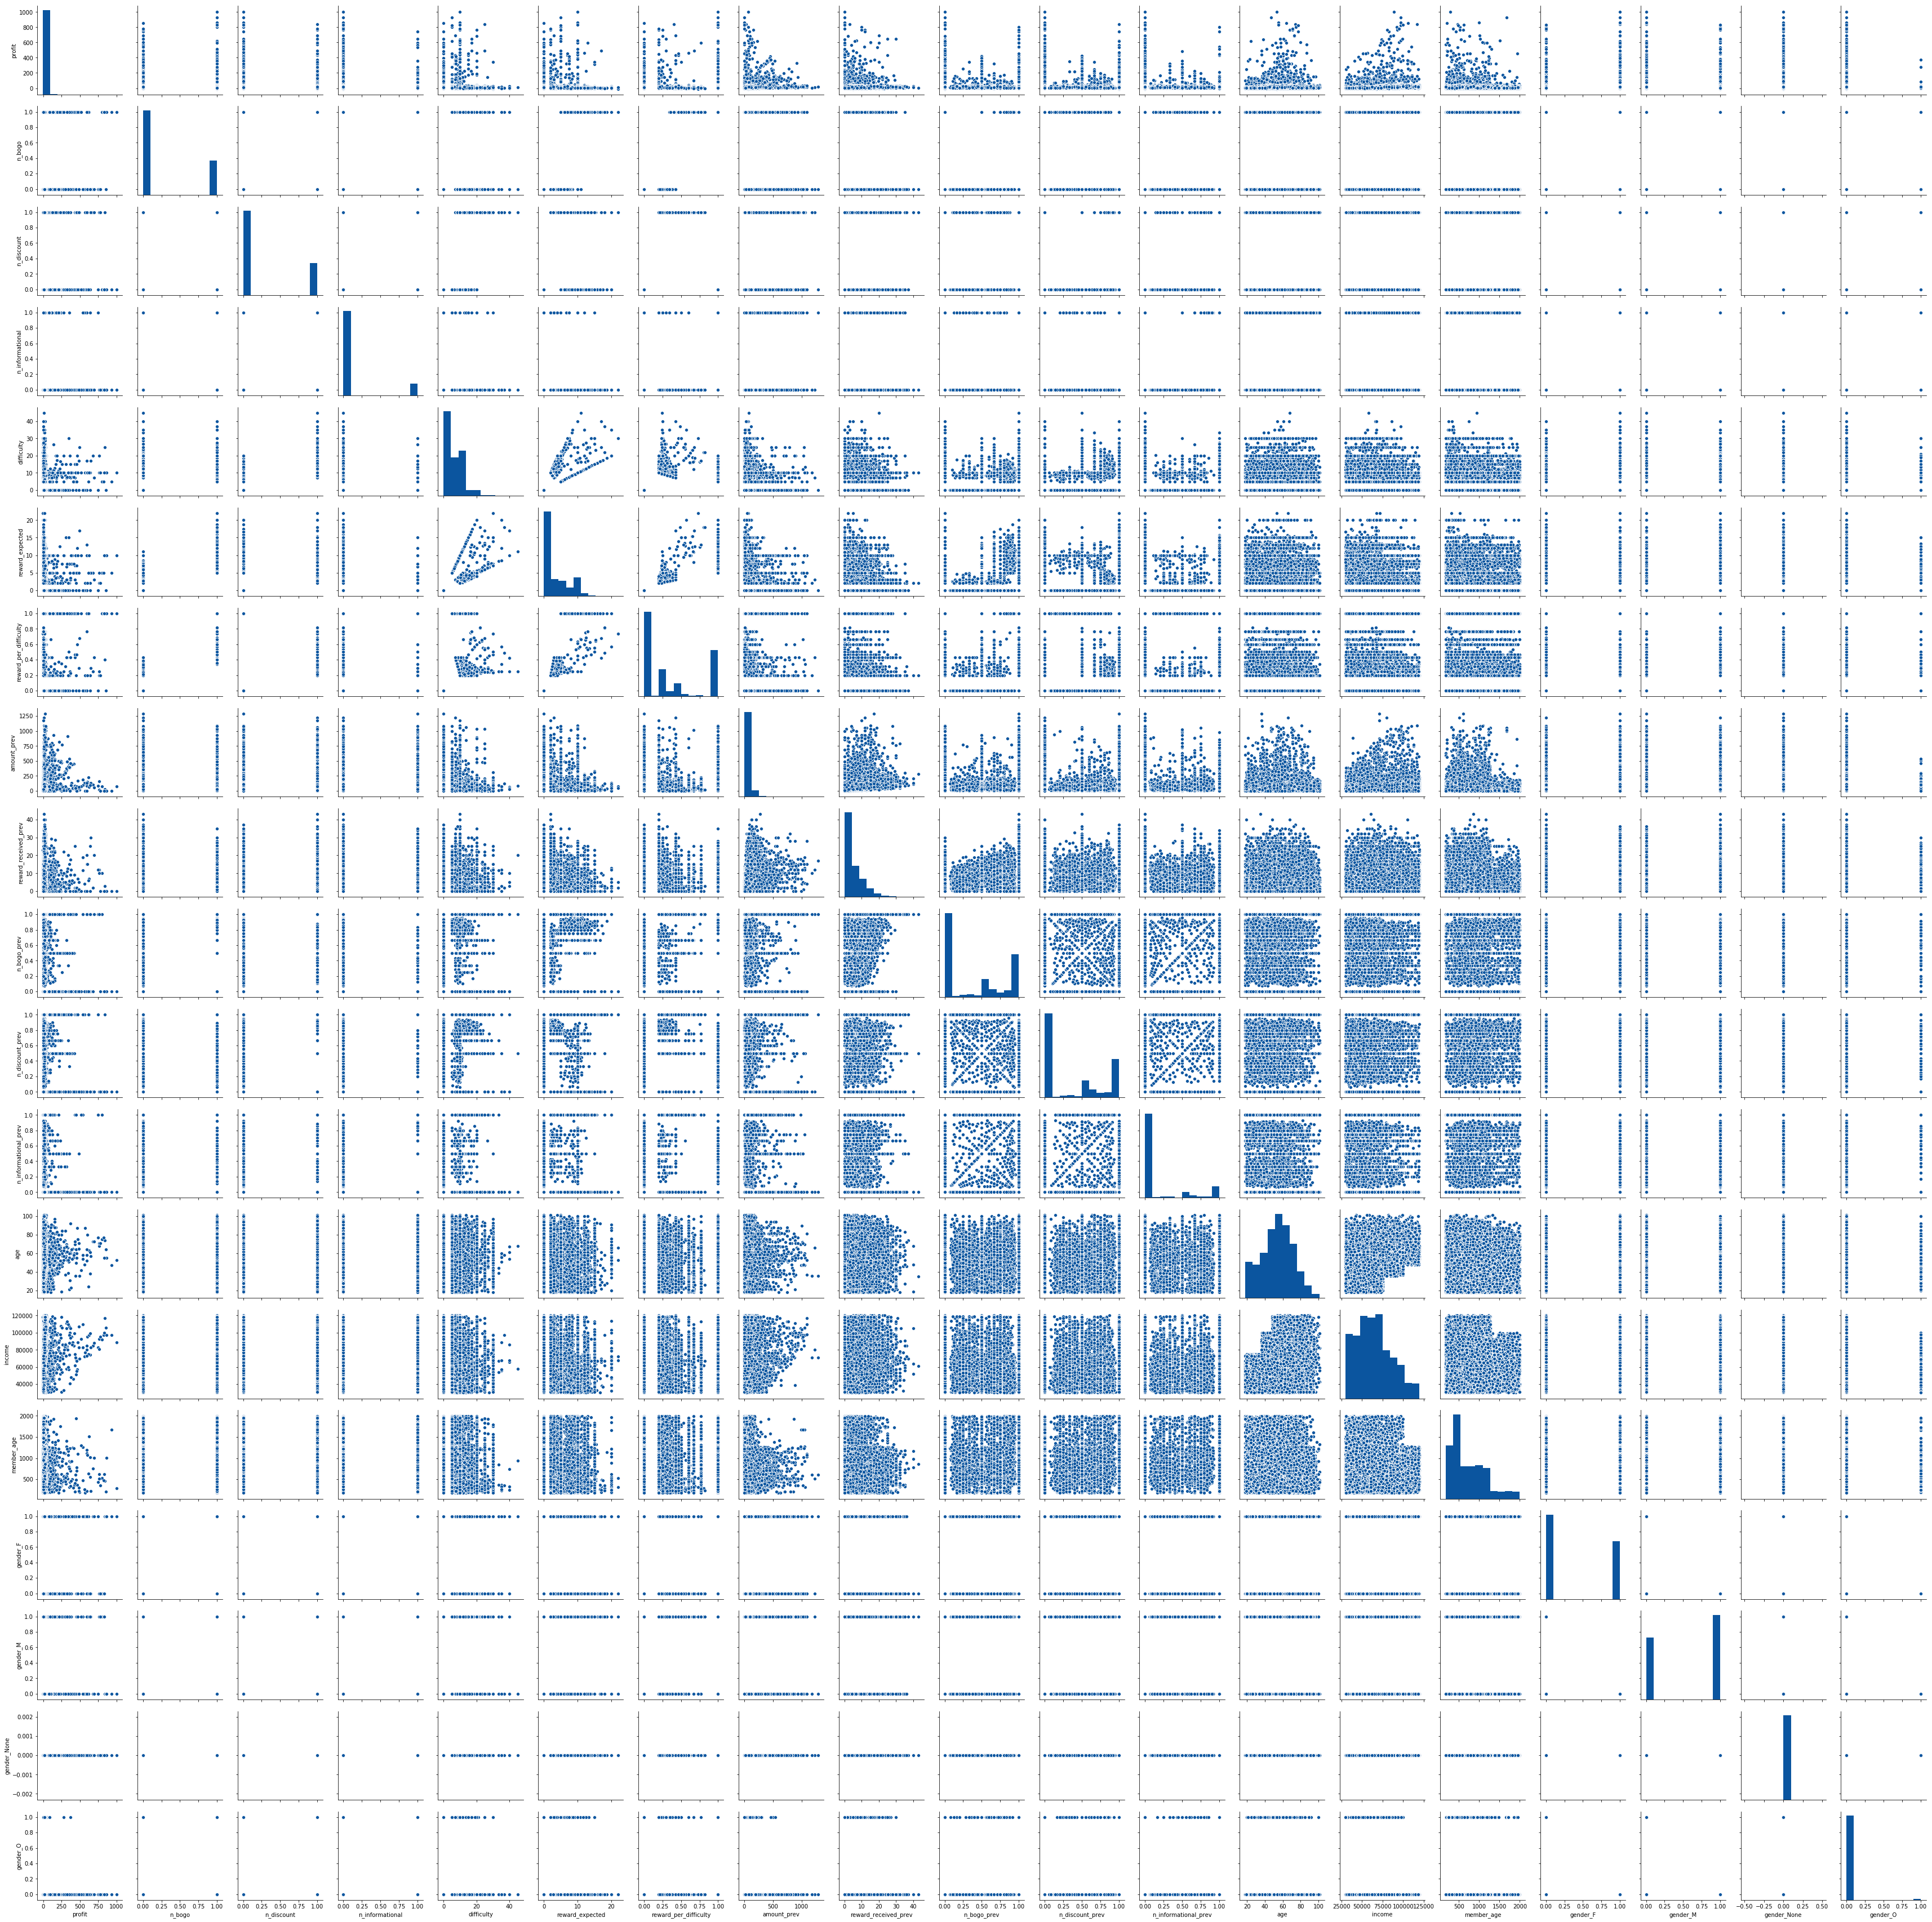

In [733]:
# Let's try to find some pattern using seaborn's pairplot
# Get names of dependent and independent variables
xy_features = ['profit','n_bogo','n_discount','n_informational','difficulty','reward_expected','reward_per_difficulty',
               'amount_prev','reward_received_prev','n_bogo_prev','n_discount_prev','n_informational_prev',
               'age','income','member_age','gender_F','gender_M','gender_None','gender_O']

# Create pairplot
p = sns.pairplot(transactions[xy_features].dropna())

#### Observations
- Many __heavliy skewed__ distributions, especially columns representing monetary values in relation to Starbucks:
    - "profit" (dependent variable)
    - "amount_prev"
    - "reward_reveived_prev"
    
As such skewed distributions may interfere with the performance our regression model, I'm going to apply a __log-transformation__ to them. This is a common approach when working with highly skewed data.

_Disclaimer: Due to quite a number of variables the plot got pretty big and labels very small, so please zoom in for details._

In [734]:
# Log-transformation
def log_transform(df, colnames):
    ''' Log transformation of list of columns
    
    Args:
        df (DataFrame):
        colnames (list):
    Returns:
        DataFrame: Returns a pandas data frame with additional log-transformed columns
    '''
    for colname in colnames:
        colname_log = colname + '_log'
        
        # Only "profit" column can have negative values as well
        # I'm going to add the max possible reward as the average profit
        # for a combination of seen offers cannot be lower than that
        constant = 10 if colname == 'profit' else 0
        df[colname_log] = np.log1p(df[colname] + constant)
        
    return df

In [735]:
# Log transformation of skewed variables
log_features = ['profit','reward_received_prev','amount_prev']
transactions = log_transform(transactions, log_features)

The pairplot above already revealed that me might face an issue with correlated features. Let's confirm this assumption by estimating __correlation coefficients__ between dependent and independent variables.

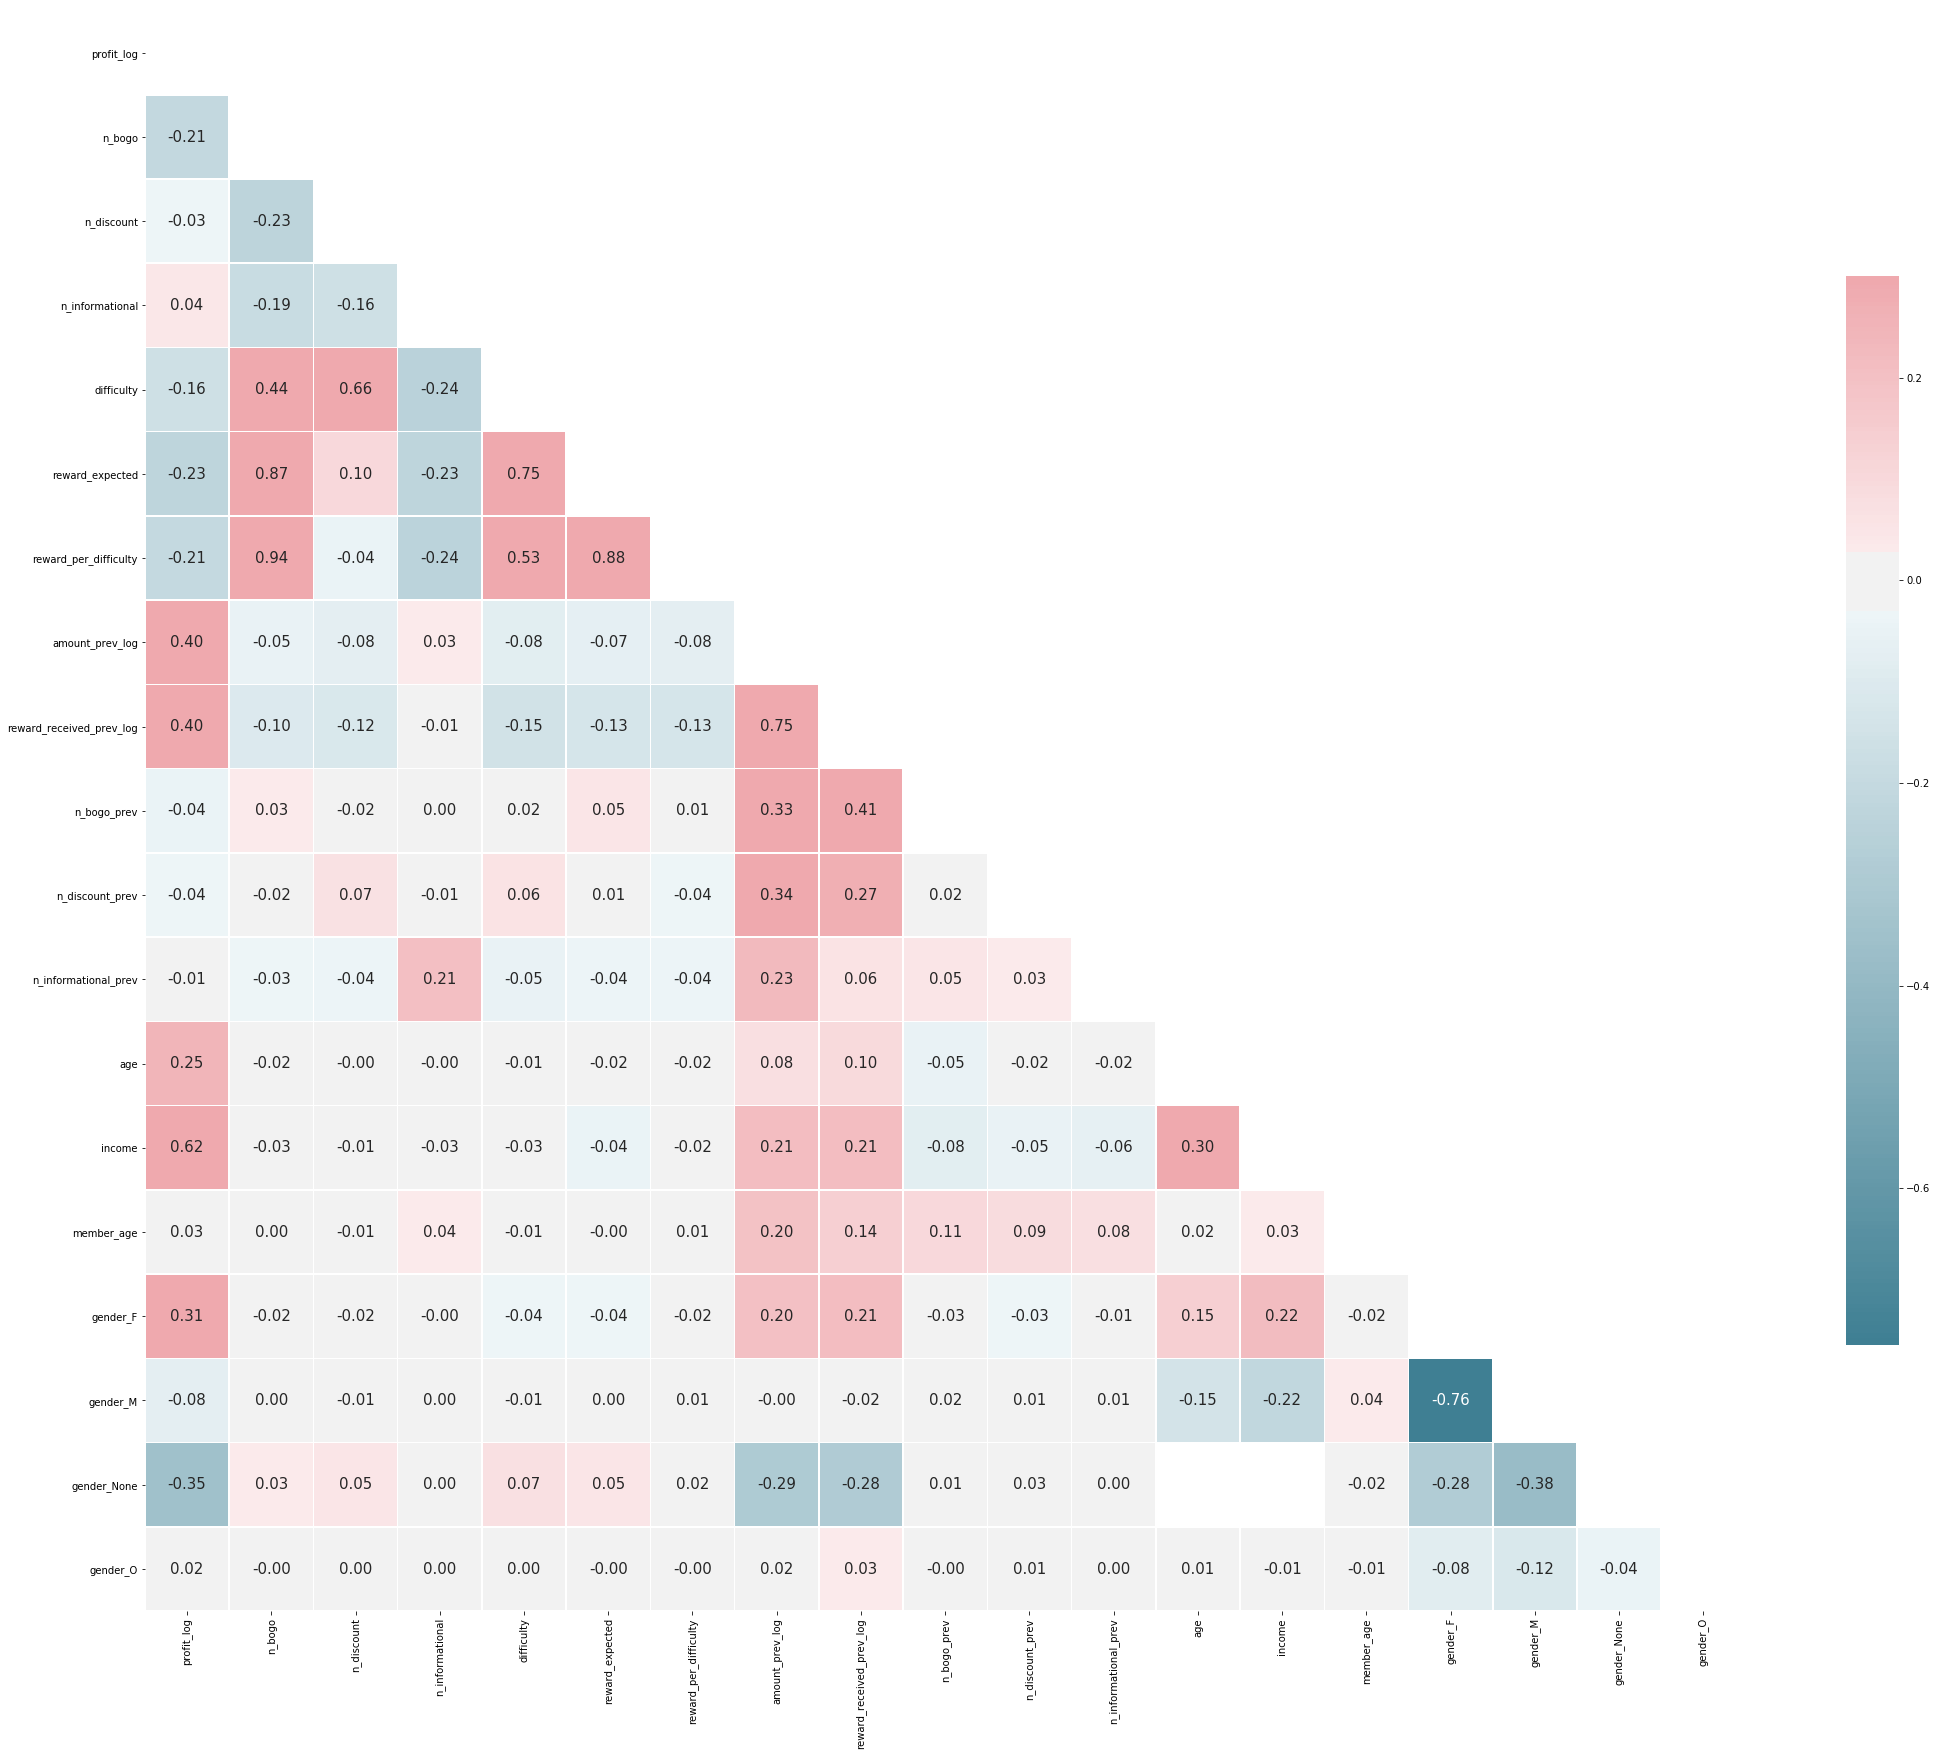

In [736]:
# Add log-transformed columns to feature set
xy_features = ['profit_log','n_bogo','n_discount','n_informational','difficulty','reward_expected','reward_per_difficulty',
               'amount_prev_log','reward_received_prev_log', 'n_bogo_prev','n_discount_prev','n_informational_prev',
               'age','income','member_age','gender_F','gender_M','gender_None','gender_O']

# Compute the correlation matrix
corrs = transactions[xy_features].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corrs, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(30, 30))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corrs, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True, fmt='.2f',
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot_kws={"size": 15})
plt.tight_layout();

#### Observations
- Many __highly correlated__ features within the data set, not only between independent, but also between independent and dependent variable
- Large correlations are likely to lead to __unstable results in linear models such as linear regression__
- Possible __solutions__:
    - Removal of correlated features (and introduction of feature crosses between correlated features)
    - Use of regularized methods such as lasso/ridge/elastic net regression
    - Use of tree-based methods such as random forest or gradient boosting

For now, I am going to stick with the second two solutions to see how far we get here. But first, to make things a bit cleaner to work with, let's put the __additional feature engineering steps__ from above into another function.

In [1295]:
def create_features(df, profile, groups=None):
    ''' Runs feature engineering pipeline on transaction data
    
    Args:
        df (DataFrame): Pandas data frame of transactions data
        profile (DataFrame): Pandas data frame of profile data
        groups (list): List of column names to use for grouping of transactions
    Returns:
        DataFrame: Returns a pandas data frame of transactions events with re-engineered columns
    '''
    print('\nPreparing data for regression model ...')
    
    # Add column for profit
    df['profit'] = df['amount'] - df['reward_received']
    
    # Add ratio between expected reward and difficulty
    df['reward_per_difficulty'] = (df['reward_expected'] / df['difficulty']).fillna(0)
    
    # Define columns for grouping
    df = df.drop(['n_offer_1','n_offer_2','n_offer_3','n_offer_4','n_offer_5','n_offer_6','n_offer_7',
                  'n_offer_8','n_offer_9','n_offer_10'], axis=1)
    
    # Add information regarding previous offer interactions and transactions
    df = add_cumsums(df)
    
    # Apply grouping
    if groups is not None:
        df = pd.DataFrame(df.groupby(groups, as_index=False).mean())

    # Add profile information
    df = add_profiles(df, profile)
    
    # Add dummies
    df = add_dummies(df, 'gender')
    
    # Add log-transformed variables
    log_features = ['profit','reward_received_prev','amount_prev']
    df = log_transform(df, log_features)
    
    print('... data prepared. Shape of data: {}'.format(df.shape))
    return df

In [1099]:
# Let's make sure we have a fresh set of our data
portfolio, profile, transcript, transactions, offer_events = pre_processing()

# Copy original transaction data frame
transactions_original = transactions.copy()

# Apply regression specific pre-processing
groups = ['person','n_bogo','n_discount','n_informational']
transactions = create_features(transactions, profile, groups)

Reading files ...
... portfolio data imported. Shape of data: (10, 6)
... profile data imported. Shape of data: (17000, 5)
... transcript data imported. Shape of data: (306137, 6)

Pre-processing data ...
... portfolio data processed. Shape of data: (10, 7)
... profile data processed. Shape of data: (17000, 5)
... rewards data processed. Shape of data: (30617, 3)
... transcript data processed. Shape of data: (306137, 8)
... transations data processed. Shape of data: (138953, 6)
... offer data processed. Shape of data: (76277, 7)

Combining data ...
... transaction events and offer periods merged and compared. Shape of data: (638479, 10)
... transaction events reshaped. Shape of data: (138953, 19)

Preparing data for regression model ...
... adding offer history
... adding profile data
... adding dummy variables
... data prepared. Shape of data: (43310, 26)


### Training

In order get going with training our first regression model we need to set up a couple of things first:

- __Split__ transaction data into training and validation partitions
- Build __regression pipeline__ which includes feature transformation such as imputation of missing values, feature scaling and a regression model
- Define function for __model validation__ to keep track of the training and validation performance measured by our secondary metrics:
    - __Adjusted$\ R^{2}$__
    - __Mean Absolute Error__ ($\\MAE$)
- Define function for model validaton based on a __reversed log-transformation__ of the target variable; this helps to evaluate $\\MAE$ on the original scale (as dependent variable was log-transformed)

Again, to keep worklows clean and compact later on, the next function combines the first to steps outlined above, thus splits the data and sets up a sklean regression pipeline.

In [1227]:
# Set up regression pipeline
def build_pipeline(df, features, target, regressor):
    ''' Build an sklearn regression pipeline
    
    Args:
        df (DataFrame): Pandas data frame of transactions data
        features (list): List of independent features
        target (str): Name of dependent feature
        regressor (Regressor): Regression model
    Returns:
        DataFrame: Pandas data frame of independent variables from training data
        DataFrame: Pandas data frame of independent variables from testing data
        Series: Pandas series of dependent variables from training data
        Series: Pandas series of dependent variables from testing data
        Pipeline: Returns a sklearn pipeline object
    '''
    print('Transforming data set ...')

    # Separate data
    X = df[features].copy()
    y = df[target].copy()

    # Split data
    print('\nSplitting data set ...')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    print('... splitting done.')
    print('... shape of training data X: {}, y {}'.format(X_train.shape, y_train.shape))
    print('... shape of testing data  X: {},  y {}'.format(X_test.shape, y_test.shape))
    
    print('\nBuilding pipeline ...')
    
    # Separate numerical from categorical features (e.g. "age")
    num_features = X.columns.tolist()
    
    # Transformation of numeric columns
    num_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', MinMaxScaler())
    ])

    # Pre-processing pipeline
    preprocessor = ColumnTransformer([
            ('num', num_transformer, num_features)
        ])

    # Create regression pipeline
    regr_pipeline = Pipeline([('preprocessor', preprocessor), ('regressor', regressor)])
    
    print('... pipeline ready.')
    
    return X_train, X_test, y_train, y_test, regr_pipeline

Next up: The two remaining functions to run model validation.

In [1114]:
def run_validation(X_train, X_test, y_train, y_test, model):
    ''' Runs model validation on test and training data
    
    Args:
        X_train (DataFrame): Pandas data frame of independent variables from training data
        X_test (DataFrame): Pandas data frame of independent variables from testing data
        y_train (Series): Pandas series of dependent variables from training data
        y_test (Series): Pandas series of dependent variables from testing data
        model (Regressor): Fitted regression model or pipeline
    Returns:
        Array: Returns an array with predicted values from training data
        Array: Returns an array with predicted values from testing data
        Dict: Returns a dictionary of validation metrics
    '''
    # Predict results for training and testing data
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    
    metrics = dict()
    
    # R2 values for training and testing data
    metrics['train_r2'] = model.score(X_train, y_train)
    metrics['train_r2adj'] = 1 - (1 - metrics['train_r2']) * (y_train.shape[0] - 1) / (y_train.shape[0] - X_train.shape[1] - 1)
    metrics['test_r2'] = model.score(X_test, y_test)
    metrics['test_r2adj'] = 1 - (1 - metrics['test_r2']) * (y_test.shape[0] - 1) / (y_test.shape[0] - X_test.shape[1] - 1)
    
    # Mean absolute error
    metrics['train_mae'] = mean_absolute_error(y_train, train_preds)
    metrics['test_mae'] = mean_absolute_error(y_test, test_preds)
    
    # RMSE
    metrics['train_rmse'] = np.sqrt(mean_squared_error(y_train, train_preds))
    metrics['test_rmse'] = np.sqrt(mean_squared_error(y_test, test_preds))
    
    # Print results
    # Training
    print('Training metrics:')
    print('R2       : {:.4f}'.format(metrics['train_r2']))
    print('R2 (adj.): {:.4f}'.format(metrics['train_r2adj']))
    print('MAE      : {:.4f}'.format(metrics['train_mae']))
    print('RMSE     : {:.4f}'.format(metrics['train_rmse']))
    
    # Testing
    print('\nValidation metrics:')
    print('R2       : {:.4f}'.format(metrics['test_r2']))
    print('R2 (adj.): {:.4f}'.format(metrics['test_r2adj']))
    print('MAE      : {:.4f}'.format(metrics['test_mae']))
    print('RMSE     : {:.4f}'.format(metrics['test_rmse']))
    
    return train_preds, test_preds, metrics

In [1115]:
def reverse_log1p(y_true, y_pred):
    ''' Runs model validation on test and training data
    
    Args:
        y_true (Array): Numpy array of log-transformed true values of dependent variables
        y_pred (Array): Numpy array of log-transformed predicted values of dependent variables
    Returns:
        DataFrame: Returns pandas data frame with true and predicted values with
                   reversed log-transformation and error measures
    '''
    # Check where the model is doing really bad
    # Create data frame of predicted and actual values
    test_vs_pred = pd.DataFrame(np.stack([y_true, y_pred]).T)

    # Reverse log1p transformation
    test_vs_pred['true_profit'] = np.expm1(test_vs_pred[0]) - 10
    test_vs_pred['pred_profit'] = np.expm1(test_vs_pred[1]) - 10
    test_vs_pred = test_vs_pred.drop([0,1], axis=1)

    # Calculate MAE & RMSE
    test_vs_pred['er'] = test_vs_pred['true_profit'] - test_vs_pred['pred_profit']
    test_vs_pred['ae'] = abs(test_vs_pred['true_profit'] - test_vs_pred['pred_profit'])
    test_vs_pred['se'] = (test_vs_pred['true_profit'] - test_vs_pred['pred_profit'])**2

    print('Validation metrics (reversed log-transformation):')
    print('MAE      : {:.4f}'.format(test_vs_pred['ae'].mean()))
    print('RMSE     : {:.4f}\n'.format(np.sqrt(test_vs_pred['se'].mean())))

    return test_vs_pred

Below I define __three__ initial regression models, one linear model as well as two tree-based models:
- ElasticNet
- GradientBoostingRegressor
- XGBRegressor

In [1170]:
# Define regressor(s)
# ElasticNet
net_regr = ElasticNetCV(l1_ratio=0.99, eps=0.001, n_alphas=1000, normalize=False,
                         max_iter=1000, cv=10, n_jobs=-1, random_state=None, tol=0.0001)

# GradientBoosting
grb_regr = GradientBoostingRegressor(n_estimators=500, learning_rate=0.01, max_depth=4,
                                    random_state=None, loss='ls', criterion='friedman_mse')

# XGBoost
xgb_regr = xgb.XGBRegressor(objective ='reg:linear', n_estimators=500, learning_rate=0.01,
                            max_depth=4, reg_alpha=0.9, reg_lambda=0.1, early_stopping_rounds=15,
                            silent=1, nthread=-1, n_jobs=-1, eval_metric='mae')

We then separate __independent and dependent__ variables from each other ...

In [1171]:
# Define features/target
target = 'profit_log'
features = ['n_bogo','n_discount','n_informational','difficulty','reward_expected','reward_per_difficulty',
            'amount_prev_log','reward_received_prev_log','n_bogo_prev','n_discount_prev','n_informational_prev',
            'age','income','member_age','gender_F','gender_M','gender_None','gender_O']

... and build our __pipelines__ so they are ready for training.

In [1228]:
# Build pipeline(s)
_, _, _, _, net_pipeline = build_pipeline(transactions, features, target, net_regr)
_, _, _, _, grb_pipeline = build_pipeline(transactions, features, target, grb_regr)
X_train, X_test, y_train, y_test, xgb_pipeline = build_pipeline(transactions, features, target, xgb_regr)

Transforming data set ...

Splitting data set ...
... splitting done.
... shape of training data X: (34648, 18), y (34648,)
... shape of testing data  X: (8662, 18),  y (8662,)

Building pipeline ...
... pipeline ready.
Transforming data set ...

Splitting data set ...
... splitting done.
... shape of training data X: (34648, 18), y (34648,)
... shape of testing data  X: (8662, 18),  y (8662,)

Building pipeline ...
... pipeline ready.
Transforming data set ...

Splitting data set ...
... splitting done.
... shape of training data X: (34648, 18), y (34648,)
... shape of testing data  X: (8662, 18),  y (8662,)

Building pipeline ...
... pipeline ready.


And finally, we __run__ the first __training round__ ...

In [1229]:
# Fit model(s)
net_pipeline.fit(X_train, y_train)
grb_pipeline.fit(X_train, y_train)
xgb_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbo...reg_alpha=0.9,
       reg_lambda=0.1, scale_pos_weight=1, seed=None, silent=1,
       subsample=1))])

### Validation

Let's see how each of the three models performs on the training and validation data. Therefore, we are going to look at our previously defined (see metrics section in project overview) secondary metrics:
- __Adjusted$\ R^{2}$__
- __Mean Absolute Error__ ($\\MAE$)

In [1230]:
# Collect metrics
print('\nElasticNet Model Performance:')
train_preds_net, test_preds_net, metrics_net = run_validation(X_train, X_test, y_train, y_test, net_pipeline)

print('\nGradientBoosting Model Performance:')
train_preds_grb, test_preds_grb, metrics_grb = run_validation(X_train, X_test, y_train, y_test, grb_pipeline)

print('\nXGBoost Model Performance:')
train_preds_xgb, test_preds_xgb, metrics_xgb = run_validation(X_train, X_test, y_train, y_test, xgb_pipeline)


ElasticNet Model Performance:
Training metrics:
R2       : 0.5495
R2 (adj.): 0.5492
MAE      : 0.1935
RMSE     : 0.2953

Validation metrics:
R2       : 0.5665
R2 (adj.): 0.5656
MAE      : 0.1923
RMSE     : 0.2916

GradientBoosting Model Performance:
Training metrics:
R2       : 0.6584
R2 (adj.): 0.6582
MAE      : 0.1586
RMSE     : 0.2571

Validation metrics:
R2       : 0.6489
R2 (adj.): 0.6482
MAE      : 0.1610
RMSE     : 0.2625

XGBoost Model Performance:
Training metrics:
R2       : 0.6552
R2 (adj.): 0.6550
MAE      : 0.1574
RMSE     : 0.2583

Validation metrics:
R2       : 0.6480
R2 (adj.): 0.6473
MAE      : 0.1597
RMSE     : 0.2628


In [1231]:
# Compare model performance after reversed log-transformation
print('ElasticNet Model Performance:')
test_vs_pred_net = reverse_log1p(y_test, test_preds_net)

print('GradientBoosting Model Performance:')
test_vs_pred_grb = reverse_log1p(y_test, test_preds_grb)

print('XGBoost Model Performance:')
test_vs_pred_xgb = reverse_log1p(y_test, test_preds_xgb)

print('Boosting Ensemble Model Performance:')
ens_preds = np.vstack([test_preds_grb, test_preds_xgb]).mean(axis=0)
ens_mae = mean_absolute_error(np.expm1(y_test) - 10, (np.expm1(ens_preds) -10))
ens_rmse = np.sqrt(mean_squared_error(np.expm1(y_test) - 10, (np.expm1(ens_preds) -10)))
print('Validation metrics (reversed log-transformation):')
print('MAE      : {:.4f}'.format(ens_mae))
print('RMSE     : {:.4f}\n'.format(ens_rmse))

ElasticNet Model Performance:
Validation metrics (reversed log-transformation):
MAE      : 5.2395
RMSE     : 23.0010

GradientBoosting Model Performance:
Validation metrics (reversed log-transformation):
MAE      : 4.6171
RMSE     : 22.5864

XGBoost Model Performance:
Validation metrics (reversed log-transformation):
MAE      : 4.6027
RMSE     : 22.6238

Boosting Ensemble Model Performance:
Validation metrics (reversed log-transformation):
MAE      : 4.6056
RMSE     : 22.6038



#### Observations
- ElasticNet performs aprroximately 12% __worse on adjusted$\ R^{2}$__ and 16% __worse on $\\MAE$__/$\\MAE_{log}$ than tree-based models
- GradientBoosting- and XGBoost-Regressors perform __similar__ in terms of __model fit__ on testing data (adjusted$\ R^{2}$ = ~0.65)
- XGBoost shows __slightly better__ performance on the test data ($\\MAE$ = 4.60 vs. 4.62)

The question that we need to ask ourself now, is: __Why__ do our models achieve only mediocre performance?

In order to improve the models I'm going to explore possible reasons for the current performance first, by analyzing possible __relationships__ between prediction errors and independent features. The analysis is done based based on __absolute error percentiles__ between true and predicted values.

Please note that this approach is different from looking at plain error plots which I will do afterwards.

In [1232]:
# Add features to data frame with errors
test_vs_pred = pd.concat([test_vs_pred_xgb.reset_index(drop=True), X_test.reset_index(drop=True)], axis=1)

# Average absolute error by error percentiles to locate difficult to predict cases
error_percentiles = test_vs_pred.groupby(pd.qcut(test_vs_pred['ae'], 100)).mean()
error_percentiles['percentile'] = [x for x in range(1,101)]

# Sort values by index and preview results
error_percentiles.sort_index(axis=0, ascending=False).head()

true_profit  pred_profit          er          ae  \
ae                                                                    
(26.263, 913.751]   164.892682    24.863003  140.029679  148.631923   
(16.178, 26.263]     30.126747    15.843363   14.283384   19.520419   
(13.288, 16.178]     25.020851    14.887135   10.133716   14.512664   
(12.067, 13.288]     21.756146    14.157092    7.599053   12.538366   
(10.855, 12.067]     19.764718    13.568421    6.196297   11.470563   

                             se    n_bogo  n_discount  n_informational  \
ae                                                                       
(26.263, 913.751]  48853.740832  0.229885    0.252874         0.103448   
(16.178, 26.263]     388.707112  0.264368    0.298851         0.149425   
(13.288, 16.178]     211.190928  0.348837    0.302326         0.197674   
(12.067, 13.288]     157.330519  0.183908    0.425287         0.206897   
(10.855, 12.067]     131.703005  0.206897    0.321839         0.287356   

                   difficulty  reward_expected  reward_per_difficulty  \
ae                                                                      
(26.263, 913.751]    4.513410         2.378352               0.295704   
(16.178, 26.263]     4.925287         2.827586               0.328070   
(13.288, 16.178]     5.744186         3.366279               0.408818   
(12.067, 13.288]     6.019157         2.593870               0.297250   
(10.855, 12.067]     4.531418         2.253257               0.283554   

                   amount_prev_log  reward_received_prev_log  n_bogo_prev  \
ae                                                                          
(26.263, 913.751]         4.399569                  1.608439     0.349562   
(16.178, 26.263]          3.399051                  1.282892     0.359595   
(13.288, 16.178]          2.979059                  1.260316     0.355814   
(12.067, 13.288]          2.859971                  1.089053     0.304981   
(10.855, 12.067]          3.089291                  1.220374     0.334291   

                   n_discount_prev  n_informational_prev        age  \
ae                                                                    
(26.263, 913.751]         0.414075              0.116845  54.113924   
(16.178, 26.263]          0.314207              0.185544  58.117647   
(13.288, 16.178]          0.310631              0.115698  58.072289   
(12.067, 13.288]          0.237165              0.070498  58.000000   
(10.855, 12.067]          0.315709              0.232184  54.717647   

                         income  member_age  gender_F  gender_M  gender_None  \
ae                                                                             
(26.263, 913.751]  73215.189873  740.103448  0.459770  0.448276     0.091954   
(16.178, 26.263]   75341.176471  744.448276  0.643678  0.310345     0.022989   
(13.288, 16.178]   78253.012048  673.976744  0.395349  0.558140     0.034884   
(12.067, 13.288]   75287.356322  762.620690  0.528736  0.459770     0.000000   
(10.855, 12.067]   76247.058824  727.390805  0.390805  0.563218     0.022989   

                   gender_O  percentile  
ae                                       
(26.263, 913.751]  0.000000         100  
(16.178, 26.263]   0.022989          99  
(13.288, 16.178]   0.011628          98  
(12.067, 13.288]   0.011494          97  
(10.855, 12.067]   0.022989          96

As it can be hard to __see any patterns__ from a table alone I am going to plot the results of the transformation below.

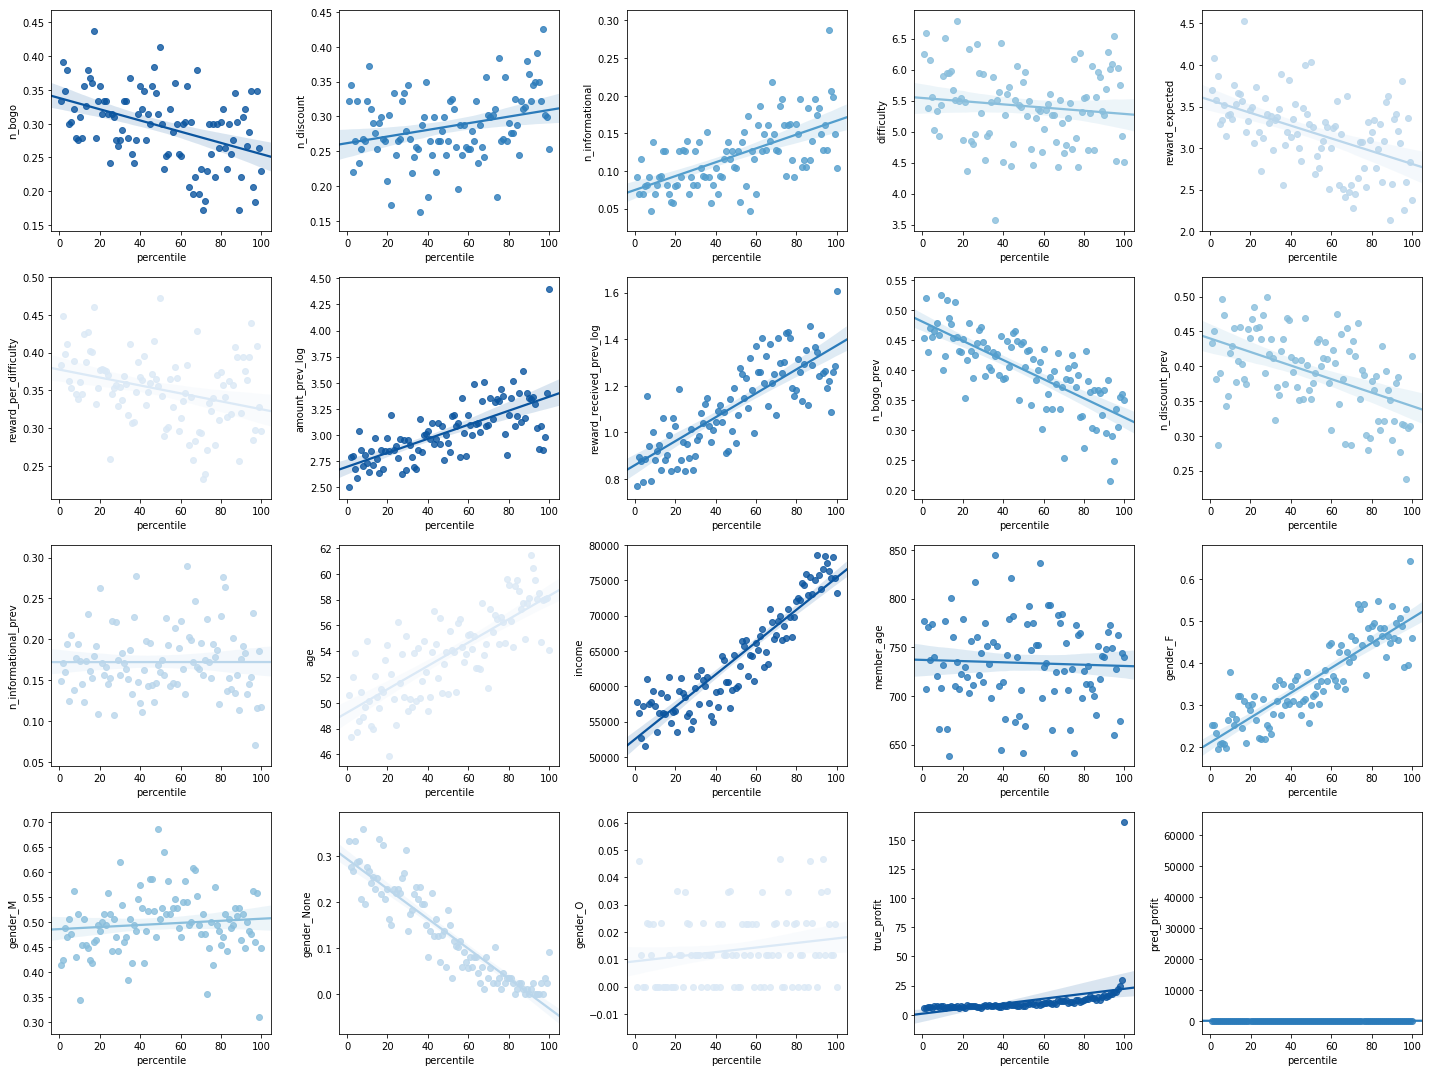

In [1233]:
# Define plotting variables
y_vars = features.copy()
y_vars.append('true_profit')
y_vars.append('pred_profit')

# Create sub-plots
fig, ax = plt.subplots(4,5, figsize = (20,15))

# Plot relationship between error percentiles and depedent/independent variable
i = 0
for row in range(4):
    for col in range(5):
        sns.regplot(x='percentile', y=y_vars[i], data=error_percentiles, ax = ax[row,col])
        ax[row,col].set_ylabel(y_vars[i])
        ax[row,col].set_xlabel('percentile')
        plt.tight_layout();
        i += 1

#### Observations
Please note,  that each percentile on the x-axis represents 1% of the test data while percentile 1 includes predictions with lowest absolute prediction errors and percentile 100 with highest absolute prediction errors. From looking at the plots above one can see clear __differences between percentiles__ for most of the columns. However, I'd only like to discuss the probably most important finding here:
- The plot having __"true_profit"__ on the y-axis reveals that the __largest error__ made by the model occurs for users with very large transaction amounts i.e. __transaction profits__
- Because such large values are rare within the data set it is __difficult to learn__ their representations
- __Removing outliers__ before training can lead to an improved training performance, but we might then __fail to predict__ such cases from unseen data
- Despite that, the __100th percentile__ also seems show much larger values for __"amount_prev_log"__

The large discrepancy between percentiles would __not have been visible__ with plain, ungrouped error plots (see below).

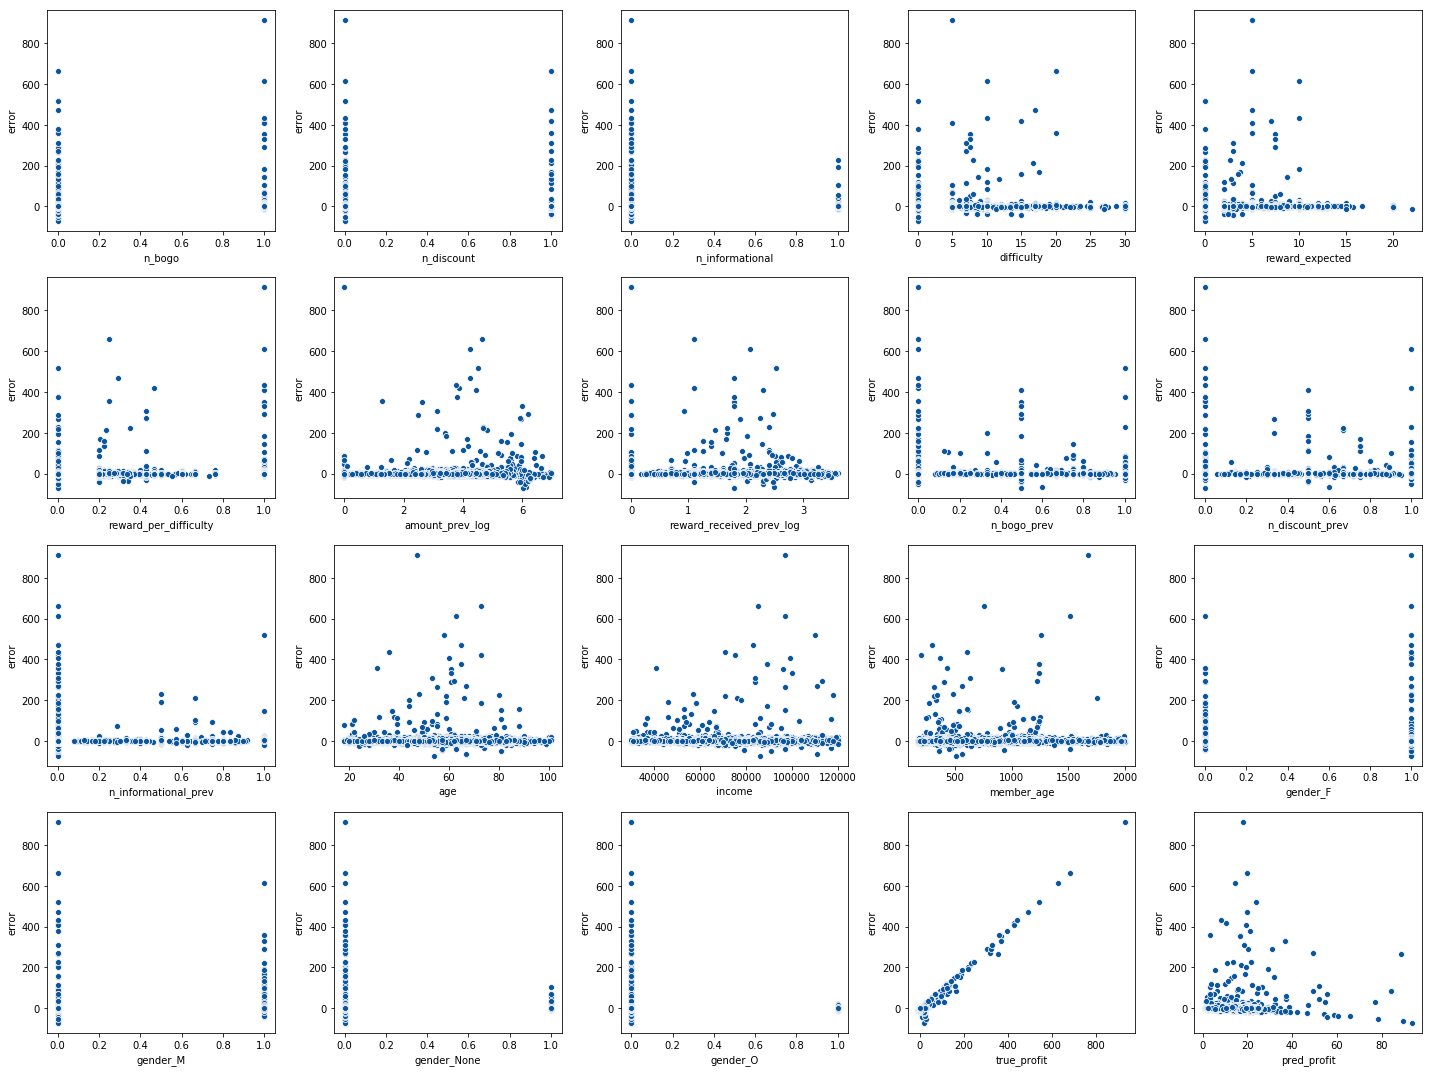

In [1234]:
# Create sub-plots
fig, ax = plt.subplots(4,5, figsize = (20,15))

# Plot relationship between actual errors and depedent/independent variable
i = 0
for row in range(4):
    for col in range(5):
        sns.scatterplot(x=y_vars[i], y='er', data=test_vs_pred, ax = ax[row,col])
        ax[row,col].set_ylabel('error')
        ax[row,col].set_xlabel(y_vars[i])
        plt.tight_layout();
        i += 1

We can also apply the same type of grouping along __percentiles of true values__ for profit per transaction.

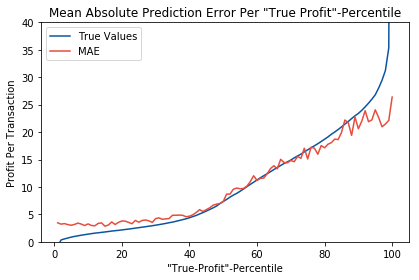

In [1338]:
# Average absolute error by error percentiles to locate difficult to predict cases
true_percentiles = test_vs_pred.groupby(pd.qcut(test_vs_pred['true_profit'], 100)).mean()
true_percentiles['percentile'] = [x for x in range(1,101)]

# Plot performance
sns.lineplot(x='percentile', y='true_profit', data=true_percentiles, label='True Values')
sns.lineplot(x='percentile', y='pred_profit', data=true_percentiles, label='MAE', color='#e74c3c')

# Formatting
plt.ylim(0,40)
plt.ylabel('Profit Per Transaction')
plt.xlabel('"True-Profit"-Percentile')
plt.title('Mean Absolute Prediction Error Per "True Profit"-Percentile')
plt.tight_layout();

Within the graph above it becomes pretty clear where our models __fails__ to perform:
- Transaction amounts that are very __very small__ are __hard to predict__ for the model
- Largest contribution to overll $\\MAE$ stems from predictions where __true values__ are __extremely large__

What we could do as well to further understand what's going on in our model is to look at the __importance of different features__.

In [1235]:
# Print feature importances
np.vstack((np.array(X_train.columns), xgb_pipeline.named_steps["regressor"].feature_importances_ * 100)).T

array([['n_bogo', 0.9860867857933044],
       ['n_discount', 1.4723761081695557],
       ['n_informational', 0.9995947480201721],
       ['difficulty', 5.632851600646973],
       ['reward_expected', 6.389301300048828],
       ['reward_per_difficulty', 5.524787425994873],
       ['amount_prev_log', 30.690261840820312],
       ['reward_received_prev_log', 4.4576520919799805],
       ['n_bogo_prev', 5.241118431091309],
       ['n_discount_prev', 4.984465599060059],
       ['n_informational_prev', 2.3098745346069336],
       ['age', 3.903822660446167],
       ['income', 16.49331283569336],
       ['member_age', 6.038092613220215],
       ['gender_F', 1.3643118143081665],
       ['gender_M', 0.16209645569324493],
       ['gender_None', 3.3499934673309326],
       ['gender_O', 0.0]], dtype=object)

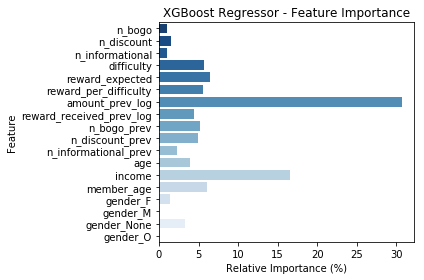

In [1236]:
# Plot features importance of XGBoost model
b = sns.barplot(x=(xgb_pipeline.named_steps["regressor"].feature_importances_ * 100),
                y=np.array(X_train.columns),
                palette='Blues_r')

plt.ylabel('Feature')
plt.xlabel('Relative Importance (%)')
plt.title('XGBoost Regressor - Feature Importance')
plt.tight_layout();

#### Observations
- Apparently, __offer types currently seen__ seem to play very little role in predicting transaction profits (3% combined only)
- In contrast, __offer types seen in the past__ show a much larger influence (13% combinded)
- The __most important__ features for prediction transaction profits stem from previously spent transaction amounts and an app users disposable income, represented by "__amount_prev_log__" (31%) and "__income__" (16%)
- The __least important__ features are in fact two gender-related dummy variables "__gender_M__" and "__gender_O__", which both show nearly 0% importance

### Tuning

I am not a big fan of removing outliers on transaction profits from the training data. These points are valid observations and we want our model to be __flexible enough__ so it can deal with such cases in unseen data in the future.

Therefore, I will go with the existing __XGBoost regressor__ (due to its slighter better test performance) and try to improve upon its performance by running a randomized __grid search__ with 5-fold cross validation over a pre-defined parameter parameter space.

Let's go ahead and define our parameter space to search over ...

In [1249]:
# Define parameters grid
parameters =  {
    'regressor__n_estimators': [1000, 1500, 2000, 2500, 3000],
    'regressor__learning_rate': [0.01 * x for x in range(1,11)],
    'regressor__max_depth': [2, 3, 4, 5, 6],
    'regressor__min_child_weight': [1, 10, 50, 100]
}

# Create cross validation object for randomized grid search
random_grid = RandomizedSearchCV(xgb_pipeline, param_distributions=parameters, cv=5, n_iter=20)

... and finally, train the models.

In [1250]:
# Fit model(s)
random_grid.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbo...reg_alpha=0.9,
       reg_lambda=0.1, scale_pos_weight=1, seed=None, silent=1,
       subsample=1))]),
          fit_params=None, iid='warn', n_iter=20, n_jobs=None,
          param_distributions={'regressor__n_estimators': [1000, 1500, 2000, 2500, 3000], 'regressor__learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1], 'regressor__max_depth': [2, 3, 4, 5, 6], 'regressor__min_child_weight': [1, 10, 50, 100]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

Let's continue by validating the performance of the __best out of 20 models__ on our test and training data.

In [1251]:
# Collect metrics for best estimator
train_preds, test_preds, metrics = run_validation(X_train, X_test, y_train, y_test, random_grid.best_estimator_)

Training metrics:
R2       : 0.7065
R2 (adj.): 0.7064
MAE      : 0.1444
RMSE     : 0.2383

Validation metrics:
R2       : 0.6614
R2 (adj.): 0.6607
MAE      : 0.1541
RMSE     : 0.2577


In [1252]:
# Get errors of data with reversed log-transformation
test_vs_pred = reverse_log1p(y_test, test_preds)

Validation metrics (reversed log-transformation):
MAE      : 4.5263
RMSE     : 22.5526



#### Observations
- Training performance improved by __8%__ on __model fit__ (adjusted$\ R^{2}$ = 0.71) and by __6%__ on transaction profit __prediction__ ($\\MAE_{log}$ = 0.14)
- Test performance improved by __2%__ on __model fit__ (adjusted$\ R^{2}$ = 0.66) and by __4%__ on transaction profit __prediction__ on log-scale, which is in fact only 2% on the orginal scale ($\\MAE_{log}$ = 0.15; $\\MAE$ = 4.53)
- The difference between training and testing performance may indicate that our model is __overfitting__

Eventhough grid search was able to find a __better parameter__ combinations for our XGBoost regression model, it still doesn't show very satisfying results. It's another example for how __difficult__ it can be to predict human behavior.

Next, we should check the parameters of our model. First of all, I want to figure out where the model actually start to overfit. Therefore, I'm going to __plot__ training and testing$\ R^{2}$ against the number of __iterations__ for each model.

In [1273]:
# Extract scoring data for train and test data
train_scores = random_grid.cv_results_['mean_train_score']
test_scores = random_grid.cv_results_['mean_test_score']
n_estimators = np.array(random_grid.cv_results_['param_regressor__n_estimators'])

/Users/patrick.peltier/miniconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


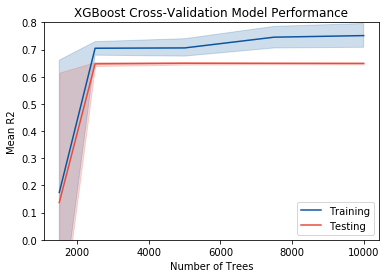

In [1274]:
# Plot performance
sns.lineplot(x=cv_n_estimators, y= cv_train_scores, label='Training')
sns.lineplot(x=cv_n_estimators, y= cv_test_scores, label='Testing', color='#e74c3c')

# Format plot
plt.ylim(.0, .8)
plt.ylabel('Mean R2')
plt.xlabel('Number of Trees')
plt.title('XGBoost Cross-Validation Model Performance')
plt.show()

Apparently, $\\R^2$ for test and training starts to diverge __after 2500__ training iterations. While the model continues to learn representations of the training data, it no longer improve its performance on the test data.

A summary of __all parameters__ of the best performing model can be found below. They confirm the optimal number of trees from the visual inspection.

In [1263]:
# Get parameters of gest model
random_grid.best_params_

{'regressor__n_estimators': 2500,
 'regressor__min_child_weight': 50,
 'regressor__max_depth': 5,
 'regressor__learning_rate': 0.01}

Last, but not least we're going to take another look at the __feature importance__ plot.

In [1277]:
# Features importance
np.vstack((np.array(X_train.columns), random_grid.best_estimator_.named_steps["regressor"].feature_importances_ * 100)).T

array([['n_bogo', 0.3039149045944214],
       ['n_discount', 0.9297397136688232],
       ['n_informational', 1.1496779918670654],
       ['difficulty', 5.280521392822266],
       ['reward_expected', 3.650977849960327],
       ['reward_per_difficulty', 2.707242012023926],
       ['amount_prev_log', 27.802213668823242],
       ['reward_received_prev_log', 8.057744026184082],
       ['n_bogo_prev', 4.488743305206299],
       ['n_discount_prev', 4.644699573516846],
       ['n_informational_prev', 2.3253488540649414],
       ['age', 8.52761173248291],
       ['income', 13.328268051147461],
       ['member_age', 13.356261253356934],
       ['gender_F', 1.0177149772644043],
       ['gender_M', 0.735793948173523],
       ['gender_None', 1.6395409107208252],
       ['gender_O', 0.053984880447387695]], dtype=object)

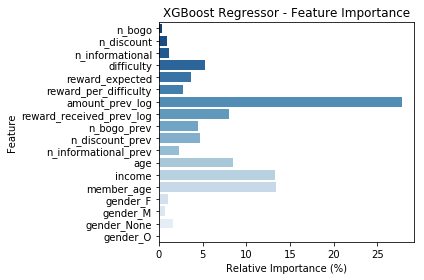

In [1261]:
# Plot features importance of XGBoost model
b = sns.barplot(x=(random_grid.best_estimator_.named_steps["regressor"].feature_importances_ * 100),
                y=np.array(X_train.columns),
                palette='Blues_r')

plt.ylabel('Feature')
plt.xlabel('Relative Importance (%)')
plt.title('XGBoost Regressor - Feature Importance')
plt.tight_layout();

#### Observations
- The influence of __offer types__ has further decreases, from a combined importance of 3% to 2% for offers seen just before making a transaction and from 13% to 11% for offers seen in the past
- While the __most important__ feature remains "__amount_prev_log__" (28%), "income" has just lost its second place to "__member_age__" (13%)

Overall, one can say that the new set of parameters has caused feature importance to __change__ for multiple independent variables.

We can now save the model to disk, in case we need it for future purposes.

In [1262]:
# Save model
joblib.dump(random_grid.best_estimator_, "xgb_regressor.pkl", compress = 1)

# Re-load from file to check if everything is correct
joblib_model = joblib.load("xgb_regressor.pkl")

# Calculate the accuracy
score = joblib_model.score(X_test, y_test)
score

0.6614411669163487

### Offer Type Prediction

Now that we've got a trained regression model in place, we can start __optimizing__ Starbucks offer strategy for individual users. The goal is to find the combination of offer types including difficulties and expected rewards that maximize an app user's transaction profit. The following steps outline this process:
- Extract __unique combinations__ of offer types, difficulties and expected rewards
- Extract app users __average offer response__ from transaction data
- __Predict__ transaction profit for every user for every combination of offer type, difficulty and expected reward
- Choose combination with __highest__ predicted transaction profit

Let's put the first two steps directly into a function ...

In [1303]:
def sim_processing(df, profile):
    ''' Runs pre-processing for offer response simulation

    Args:
        df (DataFrame): Pandas data frame of transaction events
        profile (DataFrame): Numpy array of log-transformed predicted values of dependent variables
    Returns:
        DataFrame: Returns pandas data frame with unique combinations of offer types,
                   difficulty and expected reward
        DataFrame: Returns pandas data frame with app users to run simulation for
    '''
    # Offer data pre-processing
    # Get unique combinations from transaction data set
    offers = df[['n_bogo','n_discount','n_informational','difficulty','reward_expected']].drop_duplicates()

    # User data pre-processing
    # Apply pre-processing from model training
    offer_hist = create_features(df, profile, groups=['person'])
    
    # Apply log-transformation
    log_features = ['profit','reward_received_prev','amount_prev']
    offer_hist = log_transform(offer_hist, log_features)

    # Trim data frame
    keep_cols = ['person','reward_per_difficulty','amount_prev_log','reward_received_prev_log',
                 'n_bogo_prev','n_discount_prev','n_informational_prev']
    offer_hist = offer_hist[keep_cols]
    
    # Merge with all app users
    sim_users = profile.merge(offer_hist, left_on='id', right_on='person', how='left')
    sim_users = sim_users.drop('person', axis=1)
    
    # Create dummies and adjust column positions
    sim_users = add_dummies(sim_users, 'gender')
    keep_cols = ['id','reward_per_difficulty','amount_prev_log','reward_received_prev_log','n_bogo_prev','n_discount_prev','n_informational_prev',
                 'age','income','member_age','gender_F','gender_M','gender_None','gender_O']
    sim_users = sim_users[keep_cols]

    # Fill missing values in offer history
    fill_cols = ['reward_per_difficulty','amount_prev_log','reward_received_prev_log',
                 'n_bogo_prev','n_discount_prev','n_informational_prev']
    sim_users[fill_cols] = sim_users[fill_cols].fillna(0)

    return sim_users, offers

... and then run it and preview results.

In [1304]:
# Run function
sim_users, offers = sim_processing(transactions_original, profile)

sim_users.shape, offers.shape


Preparing data for regression model ...
... adding offer history
... adding profile data
... adding dummy variables
... data prepared. Shape of data: (16578, 26)
... adding dummy variables


((17000, 14), (57, 5))

In [1305]:
# Preview offer data
offers.head()

n_bogo  n_discount  n_informational  difficulty  reward_expected
0      0.0         0.0              1.0         0.0              0.0
2      0.0         0.0              0.0         0.0              0.0
12     0.0         1.0              0.0         7.0              3.0
13     1.0         1.0              0.0        25.0             10.0
16     0.0         1.0              0.0        10.0              2.0

In [1306]:
# Preview user data
sim_users.head()

id  reward_per_difficulty  amount_prev_log  \
0  68be06ca386d4c31939f3a4f0e3dd783               0.236386         2.060938   
1  0610b486422d4921ae7d2bf64640c50b               0.000000         3.261935   
2  38fe809add3b4fcf9315a9694bb96ff5               0.000000         1.765016   
3  78afa995795e4d85b5d9ceeca43f5fef               0.285714         4.169231   
4  a03223e636434f42ac4c3df47e8bac43               0.083333         1.062409   

   reward_received_prev_log  n_bogo_prev  n_discount_prev  \
0                  0.980829     0.000000         0.888889   
1                  0.000000     0.000000         0.000000   
2                  0.000000     0.000000         0.000000   
3                  2.005334     0.857143         0.000000   
4                  0.000000     0.000000         0.666667   

   n_informational_prev   age    income  member_age  gender_F  gender_M  \
0              0.000000   NaN       NaN         705         0         0   
1              0.000000  55.0  112000.0         552         1         0   
2              0.000000   NaN       NaN         190         0         0   
3              0.571429  75.0  100000.0         619         1         0   
4              0.000000   NaN       NaN         532         0         0   

   gender_None  gender_O  
0            1         0  
1            0         0  
2            1         0  
3            0         0  
4            1         0

Nex, we define a function which __predicts transaction profits__ for every user based on each record of the offers data frame. As an output we should receive the corresponding combination of offer types, difficulties and expected rewards which maximize transaction profits. These maxized values will then be the base for estimating our primary metric $\ PPU$.

In [1308]:
# Simulate offer response based on possible offer type combinations
# and app user profile data
def get_offers(offers, sim_users, results, features):
    ''' Simulated response to different offer type combinations

    Args:
        offers (DataFrame): Pandas data frame of unique offer type combinations
        sim_users (DataFrame): Pandas data frame of users to run simulation for
        results (DataFrame): Empty pandas data frame to store in results
        features (list): List of features used for building regression model
    Returns:
        DataFrame: Returns pandas data frame with simulation results
    '''
    # Set up progressbar
    bar = progressbar.ProgressBar(maxval=sim_users.shape[0]).start()
    
    for idx, user in enumerate(sim_users['id']):
    #for user in users['id']:
        # Get features
        offers['id'] = user
        X_sim = offers.merge(sim_users, on='id', how='left')
        
        # Predict profit
        y_sim = random_grid.best_estimator_.predict(X_sim[features])
        offers['profit_sim'] = np.expm1(y_sim) - 10
        
        # Save 
        offers = offers.sort_values('profit_sim', ascending=False)
        offers['order_id'] = offers.groupby('id').cumcount() + 1
        results = pd.concat([results, offers[offers['order_id'] == 1]])
        
        # Update progressbar
        bar.update(idx)
        
    # Calculate number of user that benefit/don't benefit from offer
    n_with = results[(results['n_bogo'] != 0) | (results['n_discount'] != 0) | (results['n_informational'] != 0)].shape[0]
    n_without = results[(results['n_bogo'] == 0) & (results['n_discount'] == 0) & (results['n_informational'] == 0)].shape[0]

    return results, n_with, n_without

In [1310]:
# Create empty data frame to hold results
results = pd.DataFrame()

# Simulate offer response and extract offers likely to perform best for each user
best_offers, regr_n_with, _ = get_offers(offers, sim_users, results, features)

# Calculate PPU for regression model
regr_income = best_offers['profit_sim'].sum() / n_users

# Preview results
print(best_offers.shape)
best_offers.head()

 99% (16998 of 17000) |################# | Elapsed Time: 0:06:24 ETA:   0:00:00

(17000, 8)


n_bogo  n_discount  n_informational  difficulty  reward_expected  \
13        1.0         1.0              0.0        25.0             10.0   
0         0.0         0.0              1.0         0.0              0.0   
54788     1.0         1.0              0.0        25.0              9.0   
0         0.0         0.0              1.0         0.0              0.0   
13        1.0         1.0              0.0        25.0             10.0   

                                     id  profit_sim  order_id  
13     68be06ca386d4c31939f3a4f0e3dd783    2.781429         1  
0      0610b486422d4921ae7d2bf64640c50b   27.693554         1  
54788  38fe809add3b4fcf9315a9694bb96ff5    4.783216         1  
0      78afa995795e4d85b5d9ceeca43f5fef   25.054882         1  
13     a03223e636434f42ac4c3df47e8bac43    3.307976         1

And finally we can compare the __results__ of all our models.

In [1311]:
# Compare results
print('PPU Benchmark        : {:.2f}$, Users with Response to Offer: {}'.format(benchmark_income, benchmark_n_with))
print('PPU Demographics Top2: {:.2f}$, Users with Response to Offer: {}'.format(top2_income, top2_n_with))
print('PPU Demographics Top3: {:.2f}$, Users with Response to Offer: {}'.format(top3_income, top3_n_with))
print('PPU Demographics Top4: {:.2f}$, Users with Response to Offer: {}'.format(top4_income, top4_n_with))
print('PPU Demographics Top5: {:.2f}$, Users with Response to Offer: {}'.format(top5_income, top5_n_with))
print('PPU Regression       : {:.2f}$, Users with Response to Offer: {}'.format(regr_income, regr_n_with))

PPU Benchmark        : 11.67$, Users with Response to Offer: 15449
PPU Demographics Top2: 14.33$, Users with Response to Offer: 2305
PPU Demographics Top3: 14.55$, Users with Response to Offer: 3686
PPU Demographics Top4: 15.64$, Users with Response to Offer: 8172
PPU Demographics Top5: 17.28$, Users with Response to Offer: 8946
PPU Regression       : 12.45$, Users with Response to Offer: 13335


#### Observations
- Regression model is able to find offer type combinations for each user which __improve transaction profits__ per user by 7% with $\\PPU_{Regr} = 12.45\$$
- In this case, finding the right offers also means reaching out to __less users__ (14% less)
- Nonetheless, the XGBoost regression model __can't beat__ $\\PPU$ estimations of analytical models (13% less)

***

## 3 - Results
Before we come to a final project conlusion I'd like to take a moment to look back at and to compare the different results.

### 3.1 - Model Evaluation and Validation

### Analytical Model
- Sending out offers based on each of the variations leads to an __improvement of$\ PPU$__ by 20-44% compared to our benchmark
- Increasing the number of offer type combinations per demographic group that result from the first, the frequency based ranking, __further improves the expected$\ PPU$__
- Increased$\ PPU$ comes at the cost of __losing support__ within the data e.g. arriving at$\ PPU_{Top5} = 17.28\$$ is based on  records of 10,603 (62\%) users only
- The way the demographics groups are being created can impose quite some __uncertainty__ when leading to very small groups or even down to single users

### Regression Model
#### Model Performance
- The model achieved an adjusted$\ R^{2}$ of 0.71 and a $\\MAE_{log}$ of 0.14 during __training__
- Model performance during __testing__ has slightly decreased, showing an adjusted$\ R^{2}$ of 0.66 and $\\MAE_{log}$ = 0.15 i.e. $\\MAE$ = 4.53 respectively
- The difference between training and testing performance may indicate that our model is __overfitting__
- Apparently, $\\R^2$ for test and training starts to diverge __after 2500__ training iterations; while the model continues to learn representations of the training data, it is no longer improve its performance on the test data
- __Parameters__ of the model that balances fit, predictive performance and overfitting are:
    - Number of trees  : 2500
    - Min child weight : 50
    - Max depth        : 5
    - Learning rate    : 0.01

#### Feature Importance
- The combined influence of __offer types__ on individual transaction profits shows only relative importance of 2% for offers seen just before making a transaction and 11% for offers seen in the past
- The __most important__ feature is "__amount_prev_log__" (28%), followed by "__income__" and "__member_age__" (both ~13%)
- The results confirm that newly __created features__ such as previously paid transaction amounts can have a significant influence on a models predictive performance

#### Offer Optimization
- Regression model is able to find offer type combinations for each user which __improve transaction profits__ per user by 7% with $\\PPU_{Regr} = 12.45\$$
- Finding the right offers can sometimes mean __not sending__ any offer at all (14% less users reached with offers)

### 3.2 - Discussion
Both the analytical (and its variations) and the regression model achieve solutions that __outperform__ Starbucks' current offer sendout logic in terms of expected $\\ PPU$. The main reason for this is the fact that each of the models allows for much more __precise targeting__ which includes not sending out offers at all to particular groups of app users. Thus, Starbucks can save a lot of money on paying rewards to those customer that would have spent their money anyways. In direct comparison the __analytical model__ even __wins__ over the more sophisticated approach by 16-39% on estimated values of expected $\\ PPU$. Despite that it is much simpler to implement and explain.

Both models do have their __drawbacks__ though. Whereas the generalizability of the analytical model suffers from __rare combinations__ of offers and demographic characteristics, it's the regression model that fails to adequately __predict__ transaction profits on the lower, but especially on the __upper end__ (high transaction amounts). Please keep in mind that one shouldn't rely on a decision for one or the other as human behaviour is very often hard to predict. Rather, each of the models can serve Starbucks as a starting point for future __A/B tests__ to run within their app in order to improve their promotion strategy. Also, only then one is able to test their actual real-life performance.

***

## 4 - Conclusion
The goal of this project was to optimize Starbucks' promotion strategy or more specifically to maximize transaction profits per user. In order to do so I've explored two different approaches that would allow us to find a profit optimal combination of offer types for each of the Starbucks rewards app users. Both approaches had to prove their validity against a benchmark of Starbucks' current $\\PPU$.

The first approach is based on an (simple) __analytical solution__ that derives transaction amounts for unique offer combinations based on demographic characteristics such as age, gender and income, but also other data such as a user's app account registration date. By binning each feature along their quantiles (4x25%) we're able to find unique user groups and at the same time prevent arriving at too rare combinations. Balancing both case support for each identified group within the data as well as maximum transaction profits enables us to derive at an optimal set of offer(s) for every given user.

The second approach is based on an attempt to __directly predict__ a user's transaction profit based on his demographic characteristics as well as it's purchase and offer event history within the Starbucks rewards app. After comparing different types of models, such as __linear and tree-based regressions__, we've tuned the parameters of an XGBoostRegressor to arrive at the model of choice. The final model balances training and testing performance in terms of model fit (adjusted $\\R^{2}$) and prediction error ($\\MAE$).

While each of the developed solutions is able to __outperform the status quo__ of offer sendouts by 7-40%, it is indeed the __simpler one that wins__ their direct comparison. The analytical model used for maximizing Starbucks $\\PPU$ achieved a 16-39% better financial performance than the regression model. Nonetheless, a few drawbacks do remain. One the on hand, the analytical model suffers from __rare combinations__ of offers and demographics which end up showing little support within the data. This leaves room for uncertainty about its generalizability and real-life performance. On the other hand, the regression model __fails to adequately predict__ very low, but more importantly very high transaction amounts which cause the models overall error to appear high. Rather than choosing on solution over the other they can both serve Starbucks as a starting point for future __A/B tests__ in order to improve the promotion strategy within the Starbucks rewards app. Only then one is able to derive at a final conclusion.

***

## 5 - Limitations & Improvements
First of all, as the data sets at hand are not only simulated, but more importantly simplified versions of tracking data from the Starbucks rewards app, it remains __unclear__ if both developed solutions are __applicable in real-life__. Apart from that I do see room for improving each of the methods.

On the one hand, on could come up with more sohpisticated alternatives for deriving demographic groups from Starbucks' app users. An easy to implement approach would involve the use of __clustering methods__ such as KMeans. Though it sounds more complex at first using a clustering method can even arrive at a much simpler solution by finding meaningful groups instead of trying every combination of features.

On the other hand, going back to the phase of __feature engineering__ could potentially even lead to an improved performance of the regression model. However, deriving meaninful additional features can be difficult and most of the time requires a lot of experience. Another option is to put more focus on learning to predict the more difficult cases in the data set. One way of doing this could involve adding __oversampling__ or the addition of __synthetic__ (simulated) data. Also, on could try training __multiple models__ for different sub-groups of app users.